#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Произведем импорт всех необходимых библиотек, которые могут потребоваться в рамках данного проекта.

In [1]:
!pip install catboost

In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import random as rn
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from numpy.random import RandomState
from scipy import stats as st
from numpy.random import RandomState
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [4]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_style("darkgrid")

## Подготовка

Произведем выгрузку данных.

In [5]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Предоставленные данные являются временным рядом. Для дальнейшего анализа и подбора модели, потребуется предварительная подготовка данных.

In [9]:
df.sort_index(inplace=True)
df.index.max()

Timestamp('2018-08-31 23:50:00')

In [10]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

Из данных видно, что выгрузка предоставлена с 01.03.2018 по 31.08.2018.

Произведем ресемплирование по одному часу. В качестве агрегирующей функции будем использовать сумму, по скольку она покажет общее колличество заказов в час.

In [11]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

По результатам ознакомления с данными выявлено, что выгрузка предоставлена с марта по август 2018.
Также для дальнейшей работы проведено ресемплирование по 1 часу.

## Анализ

Проанализируем полученные данные. Для начала построим график.

<Axes: xlabel='datetime'>

<Figure size 600x800 with 0 Axes>

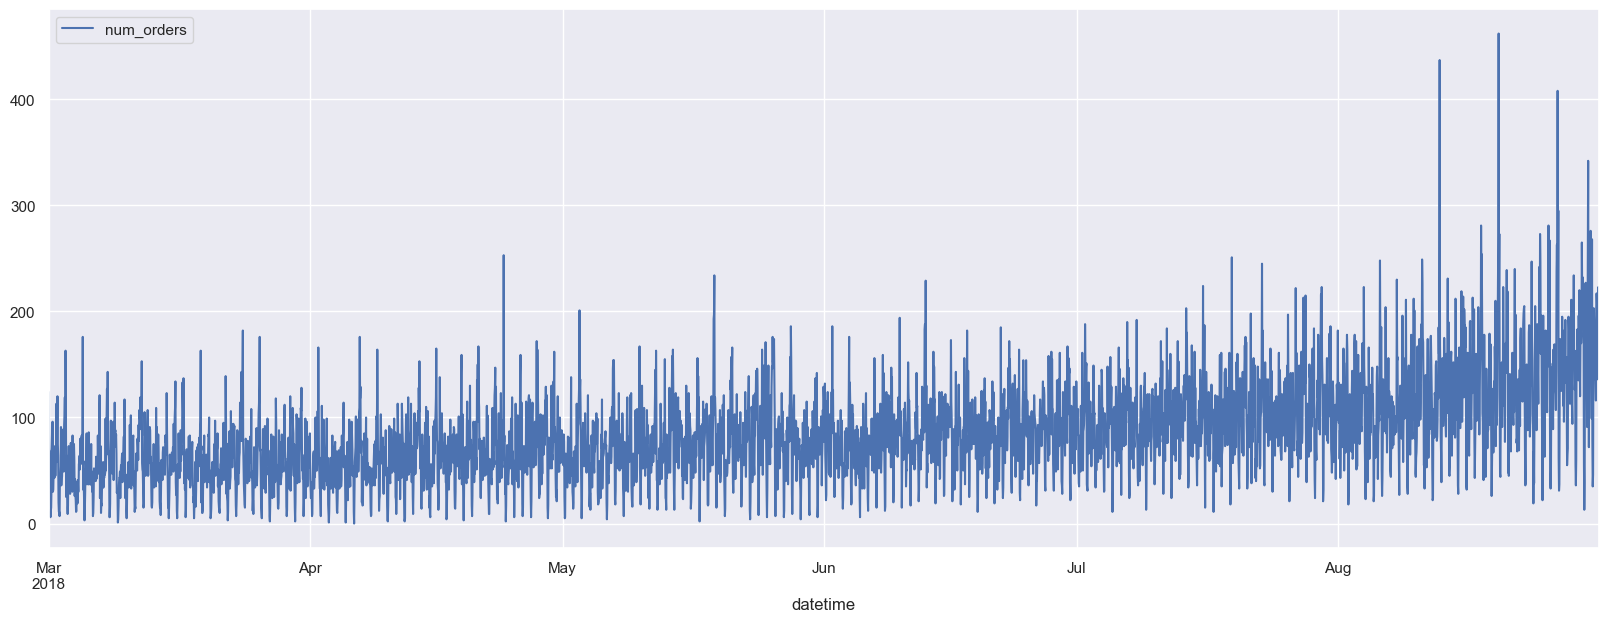

In [12]:
plt.figure(figsize=(6, 8))
df.plot()

Из данных сложно рассмотреть тренд по заказам. На первом этапе построим скользящее среднее.

<Axes: xlabel='datetime'>

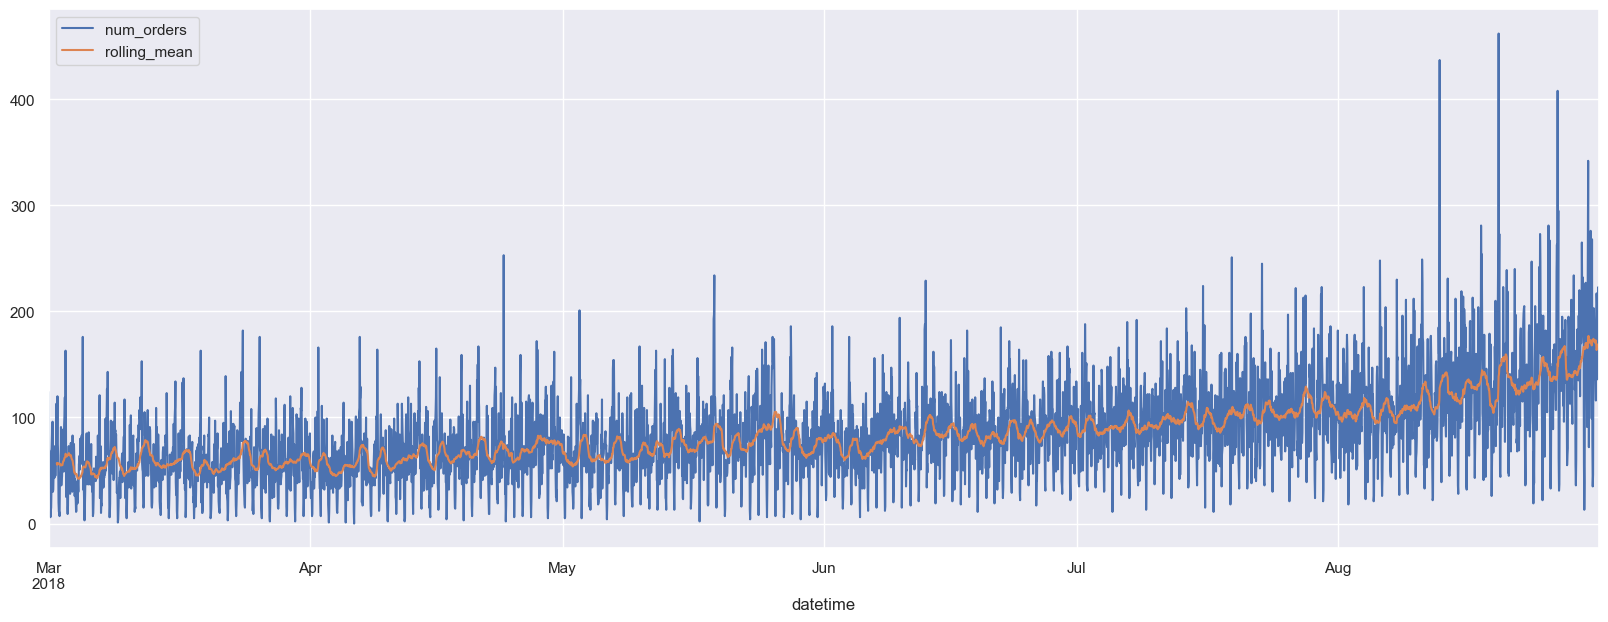

In [13]:
df['rolling_mean'] = df.rolling(24).mean()
df.plot()

Из графика видно, что наблюдается увеличение среднего колличества заказов с марта по август. 
Разобьем график на 3 составляющие (декомпозицию):

1) Тренд

2) Сезонная составляющая

3) Шумы

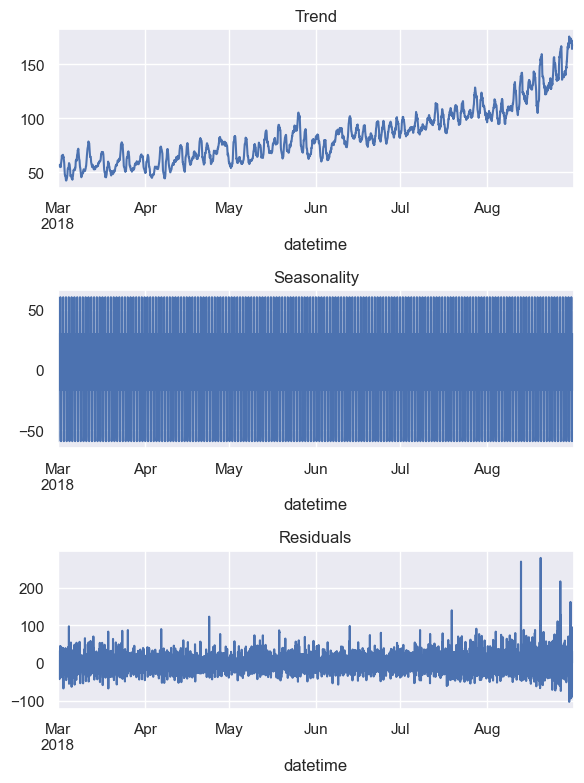

In [14]:
decomposed = seasonal_decompose(df.drop(['rolling_mean'], axis = 1))# < напишите код здесь >

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

Дополнительно рассмотрим более подробно сумму заказов в разрезе недели и месяца.

Text(0.5, 1.0, 'Seasonality_week')

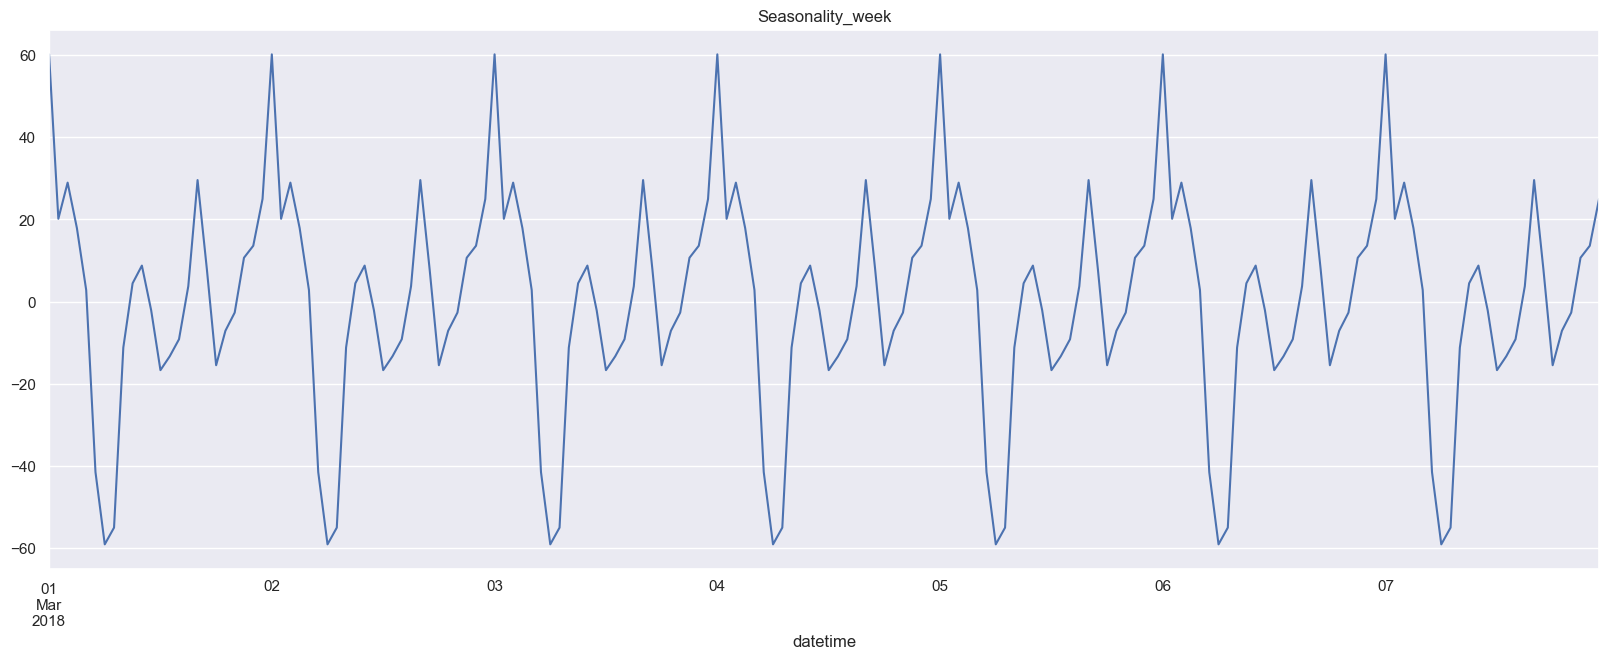

In [15]:
decomposed.seasonal['2018-03-01': '2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality_week')

Text(0.5, 1.0, 'Seasonality_week')

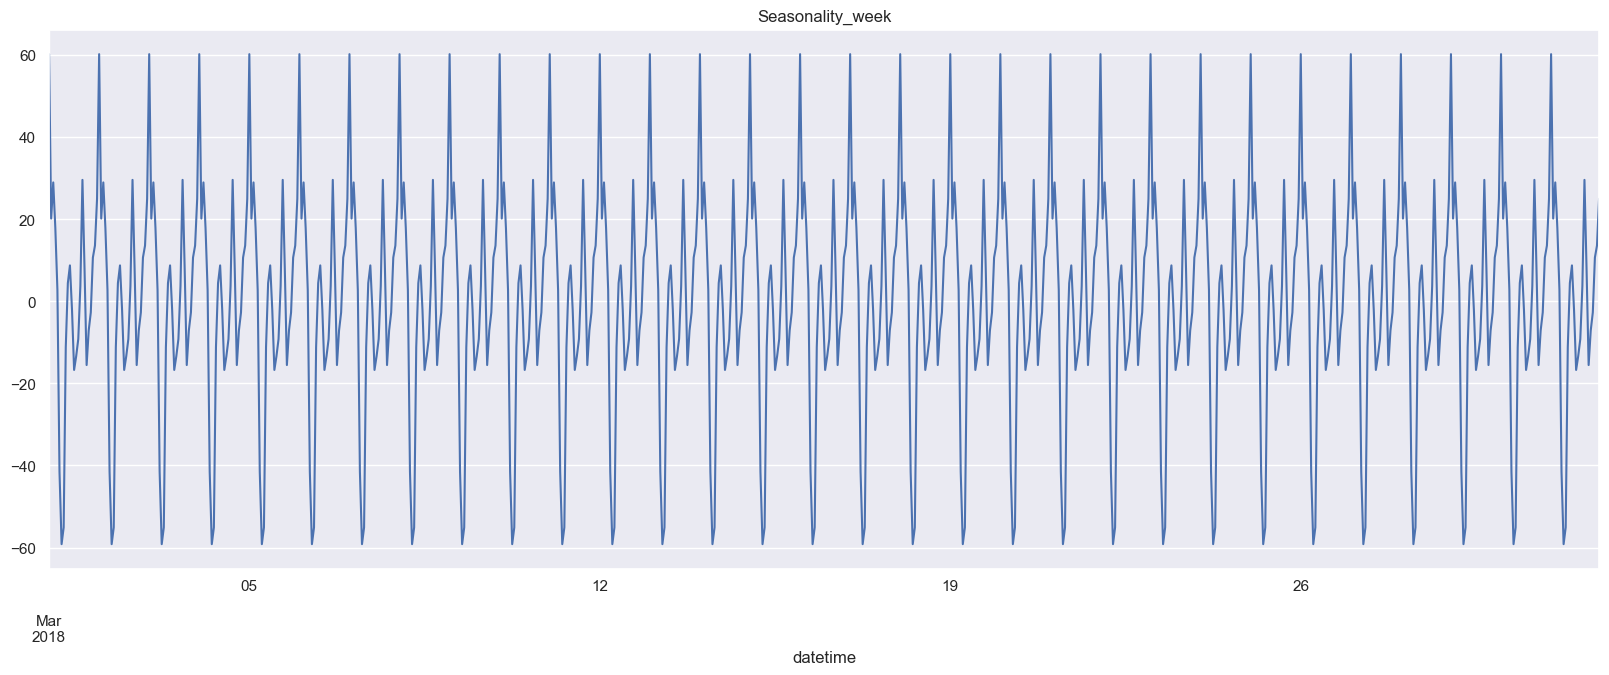

In [16]:
decomposed.seasonal['2018-03-01': '2018-03-31'].plot(ax=plt.gca())
plt.title('Seasonality_week')

### Вывод

Как было отмечено ранее, имеется тренд по увеличению суммарного колличества заказов c марта по август.

Также имеется сезонность по заказам в разрезе дня - больше всего заказов такси происходит в вечернее время.

В разрезе месяца сезонность не выраженна явно.

## Обучение

На текущем этапе у нас имеется только целевой признак - количество заказов, а именно суммарно в час.

Для предсказания целевого признака, нам потребуется создать остальные признаки.

Далее разобъем датасет на обучающую и тестовую выборку (10%).

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 20, 72)
    
df.head()

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Важно отметить, что ряд признаков при дальнейшем обучении моделей нам не потребуется:

1) year - так как данный приведены только за 6 месяцев

2) month - так как данный приведены только за 6 месяцев и этого не достаточно

3) day - так как сезонность внутри месяца отсутствует

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

Для подбора подели предсказания, рассмотрим 3: линейная регрессия, дерево решений в регрессии, случайный лес в регрессии.

1) Дерево решений в регрессии.

In [19]:
%%time
model_tree_regr = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=5)
parametrs_tree_regr = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                      'splitter': ['best', 'random'],
                      'max_depth': range (2, 7, 1) }
grid_tree_rerg = GridSearchCV(model_tree_regr, parametrs_tree_regr ,cv=tscv, scoring = 'neg_root_mean_squared_error')
grid_tree_rerg.fit(features_train, target_train)

print('Лучшие параметры DecisionTreeRegressor:', grid_tree_rerg.best_params_)
print(f'Лучшее значение MSE: {grid_tree_rerg.best_score_}')

Лучшие параметры DecisionTreeRegressor: {'criterion': 'poisson', 'max_depth': 6, 'splitter': 'best'}
Лучшее значение MSE: -30.469345813925184
CPU times: user 13.6 s, sys: 90.6 ms, total: 13.7 s
Wall time: 13.7 s


1) Случайный лес в регрессии.

In [20]:
%%time
model_random_regr = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
parametrs_random_regr = {'n_estimators': range (10, 51, 10), 
                         'max_depth': range (2, 7, 1),
                         'criterion': ['squared_error', 'absolute_error', 'poisson']
                        }
grid_random_rerg = GridSearchCV(model_random_regr, parametrs_random_regr ,cv=tscv, scoring = 'neg_root_mean_squared_error')
grid_random_rerg.fit(features_train, target_train)

print('Лучшие параметры DecisionTreeRegressor:', grid_random_rerg.best_params_)
print(f'Лучшее значение MSE: {grid_random_rerg.best_score_}')

Лучшие параметры DecisionTreeRegressor: {'criterion': 'squared_error', 'max_depth': 6, 'n_estimators': 50}
Лучшее значение MSE: -27.20866964171646
CPU times: user 10min 12s, sys: 1.68 s, total: 10min 14s
Wall time: 10min 14s


3) LightGBMRegressor

In [21]:
%%time
model_LGBM_regr = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=5)
parametrs_LGBM_regr = {'boosting_type': ['gbdt', 'dart', 'goss'], 
                       'max_depth': range (2, 7, 1),
                        }
grid_LGBM_rerg = GridSearchCV(model_LGBM_regr, parametrs_LGBM_regr ,cv=tscv, scoring = 'neg_root_mean_squared_error')
grid_LGBM_rerg.fit(features_train, target_train)

print('Лучшие параметры LGBMRegressor:', grid_LGBM_rerg.best_params_)
print(f'Лучшее значение MSE: {grid_LGBM_rerg.best_score_}')

Лучшие параметры LGBMRegressor: {'boosting_type': 'gbdt', 'max_depth': 6}
Лучшее значение MSE: -24.63675233640089
CPU times: user 28.2 s, sys: 3.06 s, total: 31.2 s
Wall time: 3.18 s


4) CatBoostRegressor

In [22]:
%%time
model_Cat_regr = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=5)
parametrs_Cat_regr = {'iterations': range (100, 300, 50), 
                      'depth': range (2, 7, 1),
                        }
grid_Cat_rerg = GridSearchCV(model_Cat_regr, parametrs_Cat_regr ,cv=tscv, scoring = 'neg_root_mean_squared_error')
grid_Cat_rerg.fit(features_train, target_train)

print('Лучшие параметры CatBoostRegressor:', grid_Cat_rerg.best_params_)
print(f'Лучшее значение MSE: {grid_Cat_rerg.best_score_}')

Learning rate set to 0.248789
0:	learn: 27.1292573	total: 58.4ms	remaining: 5.78s
1:	learn: 25.6924666	total: 58.6ms	remaining: 2.87s
2:	learn: 24.1122000	total: 58.9ms	remaining: 1.9s
3:	learn: 23.3297394	total: 59.1ms	remaining: 1.42s
4:	learn: 22.5534279	total: 59.3ms	remaining: 1.13s
5:	learn: 22.1718157	total: 59.6ms	remaining: 933ms
6:	learn: 21.4741300	total: 59.9ms	remaining: 796ms
7:	learn: 21.1041792	total: 60.2ms	remaining: 692ms
8:	learn: 20.9216309	total: 60.4ms	remaining: 610ms
9:	learn: 20.7092285	total: 60.6ms	remaining: 545ms
10:	learn: 20.3507281	total: 60.9ms	remaining: 493ms
11:	learn: 20.1783665	total: 61.2ms	remaining: 449ms
12:	learn: 19.8456637	total: 61.4ms	remaining: 411ms
13:	learn: 19.6801463	total: 61.7ms	remaining: 379ms
14:	learn: 19.4176393	total: 61.9ms	remaining: 351ms
15:	learn: 19.2733992	total: 62.1ms	remaining: 326ms
16:	learn: 19.1531782	total: 62.3ms	remaining: 304ms
17:	learn: 19.0464712	total: 62.5ms	remaining: 285ms
18:	learn: 18.8991684	total

16:	learn: 22.8612991	total: 7.78ms	remaining: 38ms
17:	learn: 22.5977094	total: 8.35ms	remaining: 38ms
18:	learn: 22.4699077	total: 8.64ms	remaining: 36.8ms
19:	learn: 22.4212436	total: 8.97ms	remaining: 35.9ms
20:	learn: 22.2985441	total: 9.29ms	remaining: 35ms
21:	learn: 22.1848106	total: 9.58ms	remaining: 34ms
22:	learn: 22.1060313	total: 9.9ms	remaining: 33.1ms
23:	learn: 21.9540849	total: 10.2ms	remaining: 32.3ms
24:	learn: 21.8830351	total: 10.5ms	remaining: 31.6ms
25:	learn: 21.7559004	total: 10.8ms	remaining: 30.8ms
26:	learn: 21.6757260	total: 11.2ms	remaining: 30.3ms
27:	learn: 21.5351697	total: 11.5ms	remaining: 29.7ms
28:	learn: 21.4437757	total: 11.9ms	remaining: 29ms
29:	learn: 21.3565354	total: 12.3ms	remaining: 28.6ms
30:	learn: 21.2988501	total: 12.7ms	remaining: 28.2ms
31:	learn: 21.2651315	total: 13ms	remaining: 27.6ms
32:	learn: 21.1527924	total: 13.4ms	remaining: 27.1ms
33:	learn: 21.0704970	total: 13.7ms	remaining: 26.6ms
34:	learn: 20.9594909	total: 14ms	remaini

Learning rate set to 0.212771
0:	learn: 30.6113458	total: 352us	remaining: 52.5ms
1:	learn: 29.0743768	total: 668us	remaining: 49.5ms
2:	learn: 28.2307845	total: 921us	remaining: 45.1ms
3:	learn: 27.5498056	total: 1.23ms	remaining: 45ms
4:	learn: 26.8914158	total: 1.55ms	remaining: 45ms
5:	learn: 26.3920067	total: 1.86ms	remaining: 44.7ms
6:	learn: 25.8970142	total: 2.15ms	remaining: 43.9ms
7:	learn: 25.6273546	total: 2.44ms	remaining: 43.2ms
8:	learn: 24.7561606	total: 2.72ms	remaining: 42.6ms
9:	learn: 24.3912100	total: 3.05ms	remaining: 42.8ms
10:	learn: 24.2383493	total: 3.34ms	remaining: 42.2ms
11:	learn: 23.9537944	total: 3.74ms	remaining: 43ms
12:	learn: 23.7268753	total: 4.1ms	remaining: 43.2ms
13:	learn: 23.5260495	total: 4.42ms	remaining: 42.9ms
14:	learn: 23.4038842	total: 4.71ms	remaining: 42.4ms
15:	learn: 23.2604768	total: 5.04ms	remaining: 42.2ms
16:	learn: 23.0159167	total: 5.3ms	remaining: 41.5ms
17:	learn: 22.8886753	total: 5.61ms	remaining: 41.1ms
18:	learn: 22.71515

114:	learn: 19.6594276	total: 51ms	remaining: 15.5ms
115:	learn: 19.6356040	total: 51.6ms	remaining: 15.1ms
116:	learn: 19.6163222	total: 52ms	remaining: 14.7ms
117:	learn: 19.5950370	total: 52.5ms	remaining: 14.2ms
118:	learn: 19.5799747	total: 52.9ms	remaining: 13.8ms
119:	learn: 19.5513764	total: 53.3ms	remaining: 13.3ms
120:	learn: 19.5490826	total: 53.7ms	remaining: 12.9ms
121:	learn: 19.5181420	total: 54.1ms	remaining: 12.4ms
122:	learn: 19.5049442	total: 54.5ms	remaining: 12ms
123:	learn: 19.4856300	total: 54.9ms	remaining: 11.5ms
124:	learn: 19.4754988	total: 55.3ms	remaining: 11.1ms
125:	learn: 19.4506231	total: 55.7ms	remaining: 10.6ms
126:	learn: 19.4360039	total: 56.1ms	remaining: 10.2ms
127:	learn: 19.4336038	total: 56.6ms	remaining: 9.72ms
128:	learn: 19.4190772	total: 57ms	remaining: 9.29ms
129:	learn: 19.3978251	total: 57.5ms	remaining: 8.85ms
130:	learn: 19.3822346	total: 58.2ms	remaining: 8.45ms
131:	learn: 19.3359961	total: 58.7ms	remaining: 8.01ms
132:	learn: 19.318

127:	learn: 18.0797404	total: 42.8ms	remaining: 24.1ms
128:	learn: 18.0539119	total: 43.4ms	remaining: 23.9ms
129:	learn: 18.0257795	total: 43.7ms	remaining: 23.5ms
130:	learn: 18.0208979	total: 43.9ms	remaining: 23.1ms
131:	learn: 18.0094337	total: 44.2ms	remaining: 22.8ms
132:	learn: 17.9867403	total: 44.5ms	remaining: 22.4ms
133:	learn: 17.9752970	total: 44.8ms	remaining: 22.1ms
134:	learn: 17.9403680	total: 45.2ms	remaining: 21.8ms
135:	learn: 17.9117637	total: 45.7ms	remaining: 21.5ms
136:	learn: 17.8763124	total: 46.2ms	remaining: 21.2ms
137:	learn: 17.8659429	total: 46.4ms	remaining: 20.9ms
138:	learn: 17.8557915	total: 46.8ms	remaining: 20.5ms
139:	learn: 17.8239329	total: 47.1ms	remaining: 20.2ms
140:	learn: 17.8007622	total: 47.4ms	remaining: 19.8ms
141:	learn: 17.7867952	total: 47.7ms	remaining: 19.5ms
142:	learn: 17.7787225	total: 48ms	remaining: 19.1ms
143:	learn: 17.7644778	total: 48.3ms	remaining: 18.8ms
144:	learn: 17.7510969	total: 48.7ms	remaining: 18.5ms
145:	learn: 

135:	learn: 19.7070462	total: 60.4ms	remaining: 28.4ms
136:	learn: 19.6968541	total: 60.9ms	remaining: 28ms
137:	learn: 19.6901201	total: 61.5ms	remaining: 27.6ms
138:	learn: 19.6723923	total: 61.8ms	remaining: 27.1ms
139:	learn: 19.6702243	total: 62.2ms	remaining: 26.7ms
140:	learn: 19.6492773	total: 62.7ms	remaining: 26.2ms
141:	learn: 19.6328208	total: 63.1ms	remaining: 25.8ms
142:	learn: 19.6097487	total: 63.5ms	remaining: 25.3ms
143:	learn: 19.5941337	total: 63.9ms	remaining: 24.8ms
144:	learn: 19.5750875	total: 64.5ms	remaining: 24.5ms
145:	learn: 19.5597061	total: 64.9ms	remaining: 24ms
146:	learn: 19.5451205	total: 65.3ms	remaining: 23.6ms
147:	learn: 19.5346529	total: 65.8ms	remaining: 23.1ms
148:	learn: 19.5195290	total: 66.2ms	remaining: 22.7ms
149:	learn: 19.5120919	total: 66.9ms	remaining: 22.3ms
150:	learn: 19.4972550	total: 67.4ms	remaining: 21.9ms
151:	learn: 19.4883236	total: 67.9ms	remaining: 21.5ms
152:	learn: 19.4798309	total: 68.4ms	remaining: 21ms
153:	learn: 19.4

10:	learn: 25.7589002	total: 3.8ms	remaining: 82.5ms
11:	learn: 25.1321533	total: 4.13ms	remaining: 81.9ms
12:	learn: 24.6574980	total: 4.41ms	remaining: 80.4ms
13:	learn: 24.4514191	total: 4.71ms	remaining: 79.5ms
14:	learn: 24.2445721	total: 4.99ms	remaining: 78.2ms
15:	learn: 24.0349298	total: 5.29ms	remaining: 77.4ms
16:	learn: 23.8056995	total: 5.59ms	remaining: 76.6ms
17:	learn: 23.6672476	total: 5.96ms	remaining: 76.9ms
18:	learn: 23.5088337	total: 6.27ms	remaining: 76.3ms
19:	learn: 23.3303089	total: 6.55ms	remaining: 75.4ms
20:	learn: 23.1822501	total: 6.81ms	remaining: 74.3ms
21:	learn: 23.1094644	total: 7.08ms	remaining: 73.4ms
22:	learn: 22.9921110	total: 7.36ms	remaining: 72.7ms
23:	learn: 22.8826667	total: 7.65ms	remaining: 72ms
24:	learn: 22.8160577	total: 7.95ms	remaining: 71.6ms
25:	learn: 22.7433213	total: 8.21ms	remaining: 70.8ms
26:	learn: 22.6473602	total: 8.49ms	remaining: 70.2ms
27:	learn: 22.4269131	total: 8.77ms	remaining: 69.5ms
28:	learn: 22.3490886	total: 9.

Learning rate set to 0.152256
0:	learn: 33.5492498	total: 474us	remaining: 118ms
1:	learn: 32.4113117	total: 891us	remaining: 111ms
2:	learn: 31.4434435	total: 1.29ms	remaining: 106ms
3:	learn: 30.6986529	total: 1.74ms	remaining: 107ms
4:	learn: 30.0407039	total: 2.11ms	remaining: 103ms
5:	learn: 29.3350201	total: 2.47ms	remaining: 101ms
6:	learn: 28.8237261	total: 2.89ms	remaining: 100ms
7:	learn: 28.3914567	total: 3.23ms	remaining: 97.8ms
8:	learn: 28.0310673	total: 3.58ms	remaining: 95.9ms
9:	learn: 27.7158436	total: 3.96ms	remaining: 94.9ms
10:	learn: 27.3009893	total: 4.4ms	remaining: 95.7ms
11:	learn: 26.6816827	total: 4.8ms	remaining: 95.1ms
12:	learn: 26.4159546	total: 5.16ms	remaining: 94.1ms
13:	learn: 26.2133039	total: 5.51ms	remaining: 93ms
14:	learn: 26.0441894	total: 5.88ms	remaining: 92.1ms
15:	learn: 25.8644607	total: 6.24ms	remaining: 91.3ms
16:	learn: 25.7288317	total: 6.65ms	remaining: 91.1ms
17:	learn: 25.6055239	total: 7.07ms	remaining: 91.1ms
18:	learn: 25.4222037

66:	learn: 15.4384375	total: 24.1ms	remaining: 11.9ms
67:	learn: 15.3853191	total: 24.6ms	remaining: 11.6ms
68:	learn: 15.3605195	total: 25.1ms	remaining: 11.3ms
69:	learn: 15.3525999	total: 25.4ms	remaining: 10.9ms
70:	learn: 15.3007888	total: 25.9ms	remaining: 10.6ms
71:	learn: 15.2366922	total: 26.2ms	remaining: 10.2ms
72:	learn: 15.1848449	total: 26.5ms	remaining: 9.8ms
73:	learn: 15.1242955	total: 26.9ms	remaining: 9.45ms
74:	learn: 15.0694586	total: 27.3ms	remaining: 9.09ms
75:	learn: 15.0088280	total: 27.6ms	remaining: 8.72ms
76:	learn: 14.9152486	total: 27.9ms	remaining: 8.34ms
77:	learn: 14.8688083	total: 28.3ms	remaining: 7.97ms
78:	learn: 14.8228314	total: 28.6ms	remaining: 7.61ms
79:	learn: 14.7690826	total: 28.9ms	remaining: 7.23ms
80:	learn: 14.7212536	total: 29.3ms	remaining: 6.87ms
81:	learn: 14.7140366	total: 29.6ms	remaining: 6.5ms
82:	learn: 14.6122031	total: 30ms	remaining: 6.14ms
83:	learn: 14.5508126	total: 30.3ms	remaining: 5.78ms
84:	learn: 14.5147834	total: 30.

82:	learn: 17.9485471	total: 50.5ms	remaining: 10.3ms
83:	learn: 17.9062312	total: 51.2ms	remaining: 9.76ms
84:	learn: 17.8807826	total: 51.8ms	remaining: 9.14ms
85:	learn: 17.8576437	total: 52.4ms	remaining: 8.52ms
86:	learn: 17.8094575	total: 52.9ms	remaining: 7.9ms
87:	learn: 17.7627131	total: 53.3ms	remaining: 7.27ms
88:	learn: 17.7452289	total: 53.9ms	remaining: 6.66ms
89:	learn: 17.7384127	total: 54.4ms	remaining: 6.04ms
90:	learn: 17.7111289	total: 54.9ms	remaining: 5.43ms
91:	learn: 17.6826074	total: 55.5ms	remaining: 4.82ms
92:	learn: 17.6442805	total: 55.9ms	remaining: 4.21ms
93:	learn: 17.6325608	total: 56.4ms	remaining: 3.6ms
94:	learn: 17.6148010	total: 56.9ms	remaining: 3ms
95:	learn: 17.5788069	total: 57.4ms	remaining: 2.39ms
96:	learn: 17.5561940	total: 57.9ms	remaining: 1.79ms
97:	learn: 17.5233058	total: 58.4ms	remaining: 1.19ms
98:	learn: 17.4833158	total: 58.9ms	remaining: 595us
99:	learn: 17.4641849	total: 59.5ms	remaining: 0us
Learning rate set to 0.178924
0:	lear

98:	learn: 16.5901204	total: 43.5ms	remaining: 22.4ms
99:	learn: 16.5533501	total: 44.1ms	remaining: 22.1ms
100:	learn: 16.5098318	total: 44.6ms	remaining: 21.6ms
101:	learn: 16.5063652	total: 45ms	remaining: 21.2ms
102:	learn: 16.4683851	total: 45.4ms	remaining: 20.7ms
103:	learn: 16.4491152	total: 45.8ms	remaining: 20.3ms
104:	learn: 16.4242683	total: 46.2ms	remaining: 19.8ms
105:	learn: 16.3919033	total: 46.6ms	remaining: 19.4ms
106:	learn: 16.3595405	total: 47ms	remaining: 18.9ms
107:	learn: 16.3320002	total: 47.5ms	remaining: 18.5ms
108:	learn: 16.2668264	total: 47.8ms	remaining: 18ms
109:	learn: 16.2442272	total: 48.2ms	remaining: 17.5ms
110:	learn: 16.1777498	total: 48.6ms	remaining: 17.1ms
111:	learn: 16.1249826	total: 49ms	remaining: 16.6ms
112:	learn: 16.1024120	total: 49.4ms	remaining: 16.2ms
113:	learn: 16.0994569	total: 49.9ms	remaining: 15.8ms
114:	learn: 16.0837880	total: 50.4ms	remaining: 15.3ms
115:	learn: 16.0614807	total: 50.8ms	remaining: 14.9ms
116:	learn: 16.05495

116:	learn: 17.7694554	total: 67.7ms	remaining: 19.1ms
117:	learn: 17.7498735	total: 68.5ms	remaining: 18.6ms
118:	learn: 17.7180230	total: 69.2ms	remaining: 18ms
119:	learn: 17.6886694	total: 69.7ms	remaining: 17.4ms
120:	learn: 17.6476894	total: 70.2ms	remaining: 16.8ms
121:	learn: 17.6220832	total: 70.7ms	remaining: 16.2ms
122:	learn: 17.6023523	total: 71.2ms	remaining: 15.6ms
123:	learn: 17.5643757	total: 71.7ms	remaining: 15ms
124:	learn: 17.5586725	total: 72.2ms	remaining: 14.4ms
125:	learn: 17.5343543	total: 72.7ms	remaining: 13.8ms
126:	learn: 17.5062955	total: 73.1ms	remaining: 13.2ms
127:	learn: 17.4778295	total: 73.6ms	remaining: 12.7ms
128:	learn: 17.4757274	total: 74.1ms	remaining: 12.1ms
129:	learn: 17.4578940	total: 74.6ms	remaining: 11.5ms
130:	learn: 17.4389714	total: 75.1ms	remaining: 10.9ms
131:	learn: 17.4147107	total: 75.8ms	remaining: 10.3ms
132:	learn: 17.3989505	total: 76.3ms	remaining: 9.75ms
133:	learn: 17.3790418	total: 76.8ms	remaining: 9.17ms
134:	learn: 17

11:	learn: 22.8521144	total: 5.21ms	remaining: 81.7ms
12:	learn: 22.5762364	total: 5.74ms	remaining: 82.5ms
13:	learn: 22.3661953	total: 6.28ms	remaining: 83.4ms
14:	learn: 22.1106104	total: 6.67ms	remaining: 82.2ms
15:	learn: 21.9195359	total: 7.03ms	remaining: 80.8ms
16:	learn: 21.7599396	total: 7.58ms	remaining: 81.6ms
17:	learn: 21.6758799	total: 7.99ms	remaining: 80.8ms
18:	learn: 21.5313560	total: 8.33ms	remaining: 79.4ms
19:	learn: 21.3660794	total: 8.74ms	remaining: 78.7ms
20:	learn: 21.2306539	total: 9.17ms	remaining: 78.2ms
21:	learn: 21.1408869	total: 9.57ms	remaining: 77.4ms
22:	learn: 21.0509650	total: 9.99ms	remaining: 76.9ms
23:	learn: 20.8951673	total: 10.5ms	remaining: 76.7ms
24:	learn: 20.8310857	total: 10.9ms	remaining: 76.2ms
25:	learn: 20.7659739	total: 11.3ms	remaining: 75.4ms
26:	learn: 20.7054691	total: 11.7ms	remaining: 75.2ms
27:	learn: 20.5980503	total: 12.1ms	remaining: 74.6ms
28:	learn: 20.5275701	total: 12.6ms	remaining: 74ms
29:	learn: 20.4865342	total: 1

182:	learn: 16.2144322	total: 94.5ms	remaining: 8.78ms
183:	learn: 16.1854918	total: 95.2ms	remaining: 8.28ms
184:	learn: 16.1796313	total: 95.7ms	remaining: 7.76ms
185:	learn: 16.1678763	total: 96.3ms	remaining: 7.25ms
186:	learn: 16.1427052	total: 96.7ms	remaining: 6.72ms
187:	learn: 16.1169513	total: 97.8ms	remaining: 6.24ms
188:	learn: 16.0959372	total: 98.3ms	remaining: 5.72ms
189:	learn: 16.0804228	total: 98.8ms	remaining: 5.2ms
190:	learn: 16.0764081	total: 99.2ms	remaining: 4.67ms
191:	learn: 16.0512701	total: 99.7ms	remaining: 4.16ms
192:	learn: 16.0277426	total: 100ms	remaining: 3.63ms
193:	learn: 16.0133523	total: 101ms	remaining: 3.11ms
194:	learn: 15.9997382	total: 101ms	remaining: 2.6ms
195:	learn: 15.9710863	total: 102ms	remaining: 2.08ms
196:	learn: 15.9671089	total: 102ms	remaining: 1.56ms
197:	learn: 15.9517174	total: 103ms	remaining: 1.04ms
198:	learn: 15.9209480	total: 103ms	remaining: 519us
199:	learn: 15.9077920	total: 104ms	remaining: 0us
Learning rate set to 0.1

141:	learn: 12.9760248	total: 41.5ms	remaining: 31.6ms
142:	learn: 12.9518117	total: 42ms	remaining: 31.4ms
143:	learn: 12.8821818	total: 42.2ms	remaining: 31.1ms
144:	learn: 12.8440519	total: 42.5ms	remaining: 30.8ms
145:	learn: 12.8284338	total: 42.8ms	remaining: 30.5ms
146:	learn: 12.8137914	total: 43.1ms	remaining: 30.2ms
147:	learn: 12.7853231	total: 43.3ms	remaining: 29.9ms
148:	learn: 12.7801167	total: 43.5ms	remaining: 29.5ms
149:	learn: 12.7656385	total: 43.8ms	remaining: 29.2ms
150:	learn: 12.7135089	total: 44.1ms	remaining: 28.9ms
151:	learn: 12.6801221	total: 44.3ms	remaining: 28.6ms
152:	learn: 12.6708901	total: 44.6ms	remaining: 28.3ms
153:	learn: 12.6323221	total: 44.9ms	remaining: 28ms
154:	learn: 12.6071524	total: 45.1ms	remaining: 27.7ms
155:	learn: 12.5619584	total: 45.4ms	remaining: 27.3ms
156:	learn: 12.5569715	total: 45.7ms	remaining: 27ms
157:	learn: 12.5523769	total: 45.9ms	remaining: 26.8ms
158:	learn: 12.5442484	total: 46.2ms	remaining: 26.4ms
159:	learn: 12.4

86:	learn: 18.2445951	total: 38.5ms	remaining: 72.1ms
87:	learn: 18.1904254	total: 39.2ms	remaining: 72.1ms
88:	learn: 18.1637204	total: 39.7ms	remaining: 71.8ms
89:	learn: 18.1181629	total: 40.2ms	remaining: 71.4ms
90:	learn: 18.0724745	total: 40.6ms	remaining: 70.9ms
91:	learn: 18.0419925	total: 41ms	remaining: 70.3ms
92:	learn: 18.0114311	total: 41.5ms	remaining: 70ms
93:	learn: 17.9734598	total: 41.9ms	remaining: 69.5ms
94:	learn: 17.9558080	total: 42.2ms	remaining: 68.9ms
95:	learn: 17.9350204	total: 42.8ms	remaining: 68.7ms
96:	learn: 17.9115369	total: 43.2ms	remaining: 68.2ms
97:	learn: 17.8816590	total: 43.6ms	remaining: 67.7ms
98:	learn: 17.8445454	total: 44ms	remaining: 67.2ms
99:	learn: 17.8010511	total: 44.5ms	remaining: 66.7ms
100:	learn: 17.7473689	total: 44.9ms	remaining: 66.3ms
101:	learn: 17.7435482	total: 45.4ms	remaining: 65.8ms
102:	learn: 17.7401880	total: 45.8ms	remaining: 65.4ms
103:	learn: 17.6900999	total: 46.3ms	remaining: 65ms
104:	learn: 17.6639760	total: 46

201:	learn: 16.5035070	total: 105ms	remaining: 25ms
202:	learn: 16.4789753	total: 106ms	remaining: 24.5ms
203:	learn: 16.4739200	total: 106ms	remaining: 24ms
204:	learn: 16.4463938	total: 107ms	remaining: 23.5ms
205:	learn: 16.4290363	total: 107ms	remaining: 22.9ms
206:	learn: 16.4150067	total: 108ms	remaining: 22.4ms
207:	learn: 16.4048768	total: 109ms	remaining: 21.9ms
208:	learn: 16.3865117	total: 109ms	remaining: 21.4ms
209:	learn: 16.3738620	total: 109ms	remaining: 20.8ms
210:	learn: 16.3607793	total: 110ms	remaining: 20.3ms
211:	learn: 16.3390778	total: 110ms	remaining: 19.8ms
212:	learn: 16.3263847	total: 111ms	remaining: 19.2ms
213:	learn: 16.3115192	total: 111ms	remaining: 18.7ms
214:	learn: 16.3084960	total: 112ms	remaining: 18.2ms
215:	learn: 16.2936843	total: 112ms	remaining: 17.6ms
216:	learn: 16.2717302	total: 112ms	remaining: 17.1ms
217:	learn: 16.2506297	total: 113ms	remaining: 16.6ms
218:	learn: 16.2406854	total: 113ms	remaining: 16.1ms
219:	learn: 16.2047470	total: 11

0:	learn: 26.8620659	total: 387us	remaining: 38.3ms
1:	learn: 25.0791890	total: 786us	remaining: 38.5ms
2:	learn: 23.4045348	total: 1.17ms	remaining: 37.9ms
3:	learn: 22.2400758	total: 1.47ms	remaining: 35.4ms
4:	learn: 21.2907675	total: 1.77ms	remaining: 33.6ms
5:	learn: 20.2504627	total: 2.1ms	remaining: 32.9ms
6:	learn: 19.6086069	total: 2.44ms	remaining: 32.5ms
7:	learn: 19.2477880	total: 2.75ms	remaining: 31.6ms
8:	learn: 18.9364137	total: 3.1ms	remaining: 31.3ms
9:	learn: 18.5558563	total: 3.44ms	remaining: 31ms
10:	learn: 18.1785642	total: 3.75ms	remaining: 30.4ms
11:	learn: 17.9076735	total: 4.07ms	remaining: 29.9ms
12:	learn: 17.7355663	total: 4.38ms	remaining: 29.3ms
13:	learn: 17.5854964	total: 4.68ms	remaining: 28.8ms
14:	learn: 17.3040877	total: 5ms	remaining: 28.3ms
15:	learn: 17.0220511	total: 5.34ms	remaining: 28ms
16:	learn: 16.9242405	total: 5.66ms	remaining: 27.6ms
17:	learn: 16.8229606	total: 6.05ms	remaining: 27.6ms
18:	learn: 16.7517223	total: 6.36ms	remaining: 27

18:	learn: 20.2680146	total: 13.3ms	remaining: 56.9ms
19:	learn: 20.1287791	total: 14.1ms	remaining: 56.5ms
20:	learn: 20.0061277	total: 14.8ms	remaining: 55.7ms
21:	learn: 19.8980950	total: 15.4ms	remaining: 54.5ms
22:	learn: 19.7743391	total: 16ms	remaining: 53.6ms
23:	learn: 19.6997137	total: 16.6ms	remaining: 52.7ms
24:	learn: 19.6314199	total: 17.3ms	remaining: 51.8ms
25:	learn: 19.4695254	total: 17.8ms	remaining: 50.8ms
26:	learn: 19.4155293	total: 18.4ms	remaining: 49.7ms
27:	learn: 19.3273245	total: 18.9ms	remaining: 48.7ms
28:	learn: 19.2300285	total: 19.4ms	remaining: 47.5ms
29:	learn: 19.1222716	total: 20ms	remaining: 46.7ms
30:	learn: 19.0599623	total: 20.6ms	remaining: 45.9ms
31:	learn: 18.9809141	total: 21.1ms	remaining: 44.9ms
32:	learn: 18.9607034	total: 21.7ms	remaining: 44.1ms
33:	learn: 18.8618643	total: 22.2ms	remaining: 43.1ms
34:	learn: 18.8526081	total: 22.9ms	remaining: 42.5ms
35:	learn: 18.7033300	total: 23.5ms	remaining: 41.9ms
36:	learn: 18.5947642	total: 24.

103:	learn: 10.7823392	total: 42.6ms	remaining: 18.8ms
104:	learn: 10.7022038	total: 43.3ms	remaining: 18.6ms
105:	learn: 10.6045153	total: 43.7ms	remaining: 18.2ms
106:	learn: 10.5943251	total: 44.2ms	remaining: 17.8ms
107:	learn: 10.5448883	total: 44.6ms	remaining: 17.3ms
108:	learn: 10.5267396	total: 44.9ms	remaining: 16.9ms
109:	learn: 10.5015794	total: 45.3ms	remaining: 16.5ms
110:	learn: 10.4189307	total: 45.7ms	remaining: 16.1ms
111:	learn: 10.3639044	total: 46.2ms	remaining: 15.7ms
112:	learn: 10.3540062	total: 46.5ms	remaining: 15.2ms
113:	learn: 10.3471465	total: 46.9ms	remaining: 14.8ms
114:	learn: 10.2763556	total: 47.3ms	remaining: 14.4ms
115:	learn: 10.2316481	total: 47.7ms	remaining: 14ms
116:	learn: 10.0996444	total: 48ms	remaining: 13.5ms
117:	learn: 10.0359870	total: 48.3ms	remaining: 13.1ms
118:	learn: 9.9755249	total: 48.8ms	remaining: 12.7ms
119:	learn: 9.8739615	total: 49.3ms	remaining: 12.3ms
120:	learn: 9.8591486	total: 49.8ms	remaining: 11.9ms
121:	learn: 9.784

133:	learn: 13.8077539	total: 75.6ms	remaining: 9.03ms
134:	learn: 13.7788397	total: 76.3ms	remaining: 8.47ms
135:	learn: 13.7129886	total: 77ms	remaining: 7.92ms
136:	learn: 13.6771166	total: 77.5ms	remaining: 7.36ms
137:	learn: 13.6737900	total: 78ms	remaining: 6.78ms
138:	learn: 13.6370816	total: 78.5ms	remaining: 6.21ms
139:	learn: 13.6181173	total: 79.1ms	remaining: 5.65ms
140:	learn: 13.5889174	total: 79.7ms	remaining: 5.08ms
141:	learn: 13.5511449	total: 80.2ms	remaining: 4.52ms
142:	learn: 13.5324996	total: 80.7ms	remaining: 3.95ms
143:	learn: 13.4773375	total: 81.2ms	remaining: 3.38ms
144:	learn: 13.4479710	total: 81.8ms	remaining: 2.82ms
145:	learn: 13.4176656	total: 82.5ms	remaining: 2.26ms
146:	learn: 13.3782831	total: 82.9ms	remaining: 1.69ms
147:	learn: 13.3299562	total: 83.6ms	remaining: 1.13ms
148:	learn: 13.3271593	total: 84.1ms	remaining: 564us
149:	learn: 13.3247745	total: 84.6ms	remaining: 0us
Learning rate set to 0.222657
0:	learn: 31.0306011	total: 1.3ms	remaining

83:	learn: 17.5719587	total: 61.2ms	remaining: 48.1ms
84:	learn: 17.5099755	total: 62.1ms	remaining: 47.5ms
85:	learn: 17.4905513	total: 62.7ms	remaining: 46.7ms
86:	learn: 17.4527013	total: 63.5ms	remaining: 46ms
87:	learn: 17.4158033	total: 64.1ms	remaining: 45.2ms
88:	learn: 17.3714326	total: 64.8ms	remaining: 44.4ms
89:	learn: 17.3683343	total: 65.5ms	remaining: 43.7ms
90:	learn: 17.3452560	total: 66.2ms	remaining: 42.9ms
91:	learn: 17.3243931	total: 66.8ms	remaining: 42.1ms
92:	learn: 17.2751840	total: 67.4ms	remaining: 41.3ms
93:	learn: 17.2357304	total: 68.1ms	remaining: 40.6ms
94:	learn: 17.1988859	total: 68.8ms	remaining: 39.8ms
95:	learn: 17.1527315	total: 69.6ms	remaining: 39.2ms
96:	learn: 17.1042595	total: 70.4ms	remaining: 38.5ms
97:	learn: 17.0523619	total: 71.4ms	remaining: 37.9ms
98:	learn: 17.0111930	total: 72.4ms	remaining: 37.3ms
99:	learn: 17.0064701	total: 73ms	remaining: 36.5ms
100:	learn: 16.9766989	total: 73.9ms	remaining: 35.9ms
101:	learn: 16.9345179	total: 7

80:	learn: 15.5329583	total: 38.2ms	remaining: 56.2ms
81:	learn: 15.4770862	total: 38.7ms	remaining: 55.8ms
82:	learn: 15.4078789	total: 39.3ms	remaining: 55.4ms
83:	learn: 15.3587910	total: 39.8ms	remaining: 55ms
84:	learn: 15.3083008	total: 40.4ms	remaining: 54.7ms
85:	learn: 15.3022721	total: 40.8ms	remaining: 54.1ms
86:	learn: 15.2967184	total: 41.2ms	remaining: 53.6ms
87:	learn: 15.2294248	total: 41.7ms	remaining: 53.1ms
88:	learn: 15.1766024	total: 42.1ms	remaining: 52.5ms
89:	learn: 15.1166084	total: 42.5ms	remaining: 52ms
90:	learn: 15.0664806	total: 42.9ms	remaining: 51.4ms
91:	learn: 14.9730738	total: 43.4ms	remaining: 50.9ms
92:	learn: 14.9055763	total: 43.7ms	remaining: 50.3ms
93:	learn: 14.8893862	total: 44.2ms	remaining: 49.8ms
94:	learn: 14.8319478	total: 44.6ms	remaining: 49.3ms
95:	learn: 14.7876539	total: 45.1ms	remaining: 48.8ms
96:	learn: 14.7213452	total: 45.6ms	remaining: 48.4ms
97:	learn: 14.6988822	total: 46.2ms	remaining: 48.1ms
98:	learn: 14.6670761	total: 46.

Learning rate set to 0.176222
0:	learn: 31.4847894	total: 1.41ms	remaining: 281ms
1:	learn: 30.2195371	total: 2.01ms	remaining: 199ms
2:	learn: 28.4673412	total: 2.57ms	remaining: 169ms
3:	learn: 27.4285330	total: 3.19ms	remaining: 156ms
4:	learn: 26.7392536	total: 3.77ms	remaining: 147ms
5:	learn: 25.7008720	total: 4.31ms	remaining: 139ms
6:	learn: 25.0755104	total: 4.84ms	remaining: 133ms
7:	learn: 24.4903703	total: 5.38ms	remaining: 129ms
8:	learn: 24.1410401	total: 5.96ms	remaining: 126ms
9:	learn: 23.6002774	total: 6.54ms	remaining: 124ms
10:	learn: 23.3503515	total: 7.07ms	remaining: 122ms
11:	learn: 23.1325215	total: 7.59ms	remaining: 119ms
12:	learn: 22.7202163	total: 8.09ms	remaining: 116ms
13:	learn: 22.5382643	total: 8.71ms	remaining: 116ms
14:	learn: 22.3612940	total: 9.37ms	remaining: 116ms
15:	learn: 22.1655599	total: 10.1ms	remaining: 116ms
16:	learn: 21.8968104	total: 10.7ms	remaining: 116ms
17:	learn: 21.7828331	total: 11.3ms	remaining: 114ms
18:	learn: 21.6298448	tota

53:	learn: 19.5382142	total: 41.2ms	remaining: 111ms
54:	learn: 19.5091432	total: 42ms	remaining: 111ms
55:	learn: 19.4810860	total: 42.6ms	remaining: 109ms
56:	learn: 19.4387546	total: 43.1ms	remaining: 108ms
57:	learn: 19.3882356	total: 43.8ms	remaining: 107ms
58:	learn: 19.3847262	total: 44.4ms	remaining: 106ms
59:	learn: 19.3090695	total: 45.1ms	remaining: 105ms
60:	learn: 19.2736067	total: 45.7ms	remaining: 104ms
61:	learn: 19.2239337	total: 46.4ms	remaining: 103ms
62:	learn: 19.1430729	total: 47.1ms	remaining: 103ms
63:	learn: 19.1115977	total: 48.2ms	remaining: 102ms
64:	learn: 19.1067419	total: 48.9ms	remaining: 102ms
65:	learn: 19.0386332	total: 49.5ms	remaining: 101ms
66:	learn: 18.9853155	total: 50.2ms	remaining: 99.7ms
67:	learn: 18.9304561	total: 51ms	remaining: 98.9ms
68:	learn: 18.8834952	total: 51.8ms	remaining: 98.3ms
69:	learn: 18.8634869	total: 52.6ms	remaining: 97.7ms
70:	learn: 18.8087777	total: 53.3ms	remaining: 96.8ms
71:	learn: 18.7573891	total: 54.1ms	remaining

187:	learn: 9.7534919	total: 73.2ms	remaining: 24.1ms
188:	learn: 9.7217137	total: 73.7ms	remaining: 23.8ms
189:	learn: 9.6862838	total: 74.1ms	remaining: 23.4ms
190:	learn: 9.6473485	total: 74.6ms	remaining: 23ms
191:	learn: 9.6279056	total: 75.1ms	remaining: 22.7ms
192:	learn: 9.5982861	total: 75.4ms	remaining: 22.3ms
193:	learn: 9.5593623	total: 75.7ms	remaining: 21.9ms
194:	learn: 9.5502457	total: 76.1ms	remaining: 21.5ms
195:	learn: 9.5208802	total: 76.4ms	remaining: 21.1ms
196:	learn: 9.4995456	total: 76.8ms	remaining: 20.7ms
197:	learn: 9.4553120	total: 77.2ms	remaining: 20.3ms
198:	learn: 9.4476161	total: 77.6ms	remaining: 19.9ms
199:	learn: 9.3972897	total: 78ms	remaining: 19.5ms
200:	learn: 9.3572387	total: 78.4ms	remaining: 19.1ms
201:	learn: 9.3220055	total: 78.9ms	remaining: 18.7ms
202:	learn: 9.2641146	total: 79.3ms	remaining: 18.4ms
203:	learn: 9.2167408	total: 79.7ms	remaining: 18ms
204:	learn: 9.2023461	total: 80.2ms	remaining: 17.6ms
205:	learn: 9.1814383	total: 81.4m

32:	learn: 19.7768993	total: 18.4ms	remaining: 121ms
33:	learn: 19.6727658	total: 19.1ms	remaining: 121ms
34:	learn: 19.5746224	total: 19.8ms	remaining: 121ms
35:	learn: 19.5185605	total: 20.3ms	remaining: 121ms
36:	learn: 19.4391671	total: 20.8ms	remaining: 120ms
37:	learn: 19.3679226	total: 21.4ms	remaining: 119ms
38:	learn: 19.3156525	total: 21.9ms	remaining: 119ms
39:	learn: 19.2434040	total: 22.4ms	remaining: 118ms
40:	learn: 19.1772868	total: 22.9ms	remaining: 117ms
41:	learn: 19.1465667	total: 23.5ms	remaining: 116ms
42:	learn: 19.1058538	total: 24ms	remaining: 116ms
43:	learn: 19.0423329	total: 24.6ms	remaining: 115ms
44:	learn: 18.9709470	total: 25.2ms	remaining: 115ms
45:	learn: 18.9308236	total: 25.8ms	remaining: 115ms
46:	learn: 18.8373502	total: 26.5ms	remaining: 114ms
47:	learn: 18.7881769	total: 27.1ms	remaining: 114ms
48:	learn: 18.7367994	total: 27.8ms	remaining: 114ms
49:	learn: 18.6568027	total: 28.4ms	remaining: 114ms
50:	learn: 18.6098192	total: 29ms	remaining: 113

78:	learn: 18.4638553	total: 51.9ms	remaining: 112ms
79:	learn: 18.3830120	total: 52.7ms	remaining: 112ms
80:	learn: 18.3354641	total: 53.3ms	remaining: 111ms
81:	learn: 18.3296868	total: 53.8ms	remaining: 110ms
82:	learn: 18.2762700	total: 54.3ms	remaining: 109ms
83:	learn: 18.2101313	total: 55ms	remaining: 109ms
84:	learn: 18.1659041	total: 55.5ms	remaining: 108ms
85:	learn: 18.1626865	total: 56.1ms	remaining: 107ms
86:	learn: 18.1256930	total: 56.8ms	remaining: 106ms
87:	learn: 18.0650404	total: 57.4ms	remaining: 106ms
88:	learn: 18.0100356	total: 57.9ms	remaining: 105ms
89:	learn: 17.9677184	total: 58.7ms	remaining: 104ms
90:	learn: 17.9319736	total: 59.3ms	remaining: 104ms
91:	learn: 17.8879501	total: 59.9ms	remaining: 103ms
92:	learn: 17.8325419	total: 60.6ms	remaining: 102ms
93:	learn: 17.7938496	total: 61.2ms	remaining: 102ms
94:	learn: 17.7313551	total: 61.8ms	remaining: 101ms
95:	learn: 17.7037112	total: 62.5ms	remaining: 100ms
96:	learn: 17.6687502	total: 63.3ms	remaining: 9

91:	learn: 18.5892772	total: 67.8ms	remaining: 116ms
92:	learn: 18.5594917	total: 68.6ms	remaining: 116ms
93:	learn: 18.5188629	total: 69.4ms	remaining: 115ms
94:	learn: 18.4859840	total: 70ms	remaining: 114ms
95:	learn: 18.4512294	total: 70.6ms	remaining: 113ms
96:	learn: 18.4166633	total: 71.3ms	remaining: 112ms
97:	learn: 18.4051262	total: 71.9ms	remaining: 111ms
98:	learn: 18.3603806	total: 72.5ms	remaining: 111ms
99:	learn: 18.3365646	total: 73.2ms	remaining: 110ms
100:	learn: 18.3059367	total: 73.8ms	remaining: 109ms
101:	learn: 18.2827110	total: 74.4ms	remaining: 108ms
102:	learn: 18.2432585	total: 75ms	remaining: 107ms
103:	learn: 18.2176227	total: 75.7ms	remaining: 106ms
104:	learn: 18.1930647	total: 76.3ms	remaining: 105ms
105:	learn: 18.1528359	total: 77.1ms	remaining: 105ms
106:	learn: 18.1253787	total: 77.7ms	remaining: 104ms
107:	learn: 18.0942759	total: 78.4ms	remaining: 103ms
108:	learn: 18.0578001	total: 79.1ms	remaining: 102ms
109:	learn: 18.0273157	total: 79.9ms	rema

0:	learn: 28.1631931	total: 754us	remaining: 74.7ms
1:	learn: 26.5317341	total: 1.31ms	remaining: 64.3ms
2:	learn: 24.3202532	total: 1.81ms	remaining: 58.5ms
3:	learn: 22.9247370	total: 2.41ms	remaining: 57.9ms
4:	learn: 22.0478223	total: 2.98ms	remaining: 56.6ms
5:	learn: 21.3625458	total: 3.49ms	remaining: 54.6ms
6:	learn: 20.7443872	total: 3.98ms	remaining: 52.9ms
7:	learn: 20.3146519	total: 4.51ms	remaining: 51.8ms
8:	learn: 19.7845699	total: 5.7ms	remaining: 57.6ms
9:	learn: 19.4273986	total: 6.25ms	remaining: 56.2ms
10:	learn: 19.1382989	total: 6.79ms	remaining: 55ms
11:	learn: 18.8249933	total: 7.33ms	remaining: 53.7ms
12:	learn: 18.4959228	total: 7.87ms	remaining: 52.6ms
13:	learn: 18.3669683	total: 8.46ms	remaining: 51.9ms
14:	learn: 18.1500929	total: 8.96ms	remaining: 50.8ms
15:	learn: 17.9282107	total: 9.5ms	remaining: 49.9ms
16:	learn: 17.7588266	total: 10.1ms	remaining: 49.3ms
17:	learn: 17.5166044	total: 10.7ms	remaining: 48.7ms
18:	learn: 17.4187532	total: 11.4ms	remaini

37:	learn: 17.2720137	total: 31.9ms	remaining: 52.1ms
38:	learn: 17.2632132	total: 32.8ms	remaining: 51.4ms
39:	learn: 17.2257410	total: 33.7ms	remaining: 50.6ms
40:	learn: 17.1177596	total: 34.4ms	remaining: 49.6ms
41:	learn: 16.9702079	total: 35.3ms	remaining: 48.7ms
42:	learn: 16.8402150	total: 36.1ms	remaining: 47.9ms
43:	learn: 16.7411085	total: 36.9ms	remaining: 47ms
44:	learn: 16.6271668	total: 37.7ms	remaining: 46ms
45:	learn: 16.5387377	total: 38.4ms	remaining: 45.1ms
46:	learn: 16.4272243	total: 39.3ms	remaining: 44.4ms
47:	learn: 16.3439183	total: 40.1ms	remaining: 43.5ms
48:	learn: 16.2600642	total: 40.9ms	remaining: 42.6ms
49:	learn: 16.2151447	total: 42ms	remaining: 42ms
50:	learn: 16.1519544	total: 42.8ms	remaining: 41.1ms
51:	learn: 16.0439703	total: 43.8ms	remaining: 40.4ms
52:	learn: 15.9580532	total: 44.8ms	remaining: 39.7ms
53:	learn: 15.8792325	total: 45.6ms	remaining: 38.8ms
54:	learn: 15.7918978	total: 46.5ms	remaining: 38ms
55:	learn: 15.7297886	total: 47.3ms	re

50:	learn: 12.6831459	total: 28.8ms	remaining: 55.9ms
51:	learn: 12.5146108	total: 29.6ms	remaining: 55.7ms
52:	learn: 12.4275096	total: 30.2ms	remaining: 55.3ms
53:	learn: 12.3830806	total: 30.7ms	remaining: 54.5ms
54:	learn: 12.3235103	total: 31.2ms	remaining: 53.8ms
55:	learn: 12.3031559	total: 31.6ms	remaining: 53ms
56:	learn: 12.2241120	total: 32.1ms	remaining: 52.4ms
57:	learn: 12.0912142	total: 32.6ms	remaining: 51.7ms
58:	learn: 11.9883755	total: 33.1ms	remaining: 51ms
59:	learn: 11.8776976	total: 34ms	remaining: 51ms
60:	learn: 11.6885113	total: 34.6ms	remaining: 50.5ms
61:	learn: 11.6169955	total: 35.2ms	remaining: 50ms
62:	learn: 11.4996685	total: 35.9ms	remaining: 49.6ms
63:	learn: 11.4860567	total: 36.5ms	remaining: 49ms
64:	learn: 11.3718666	total: 37.2ms	remaining: 48.7ms
65:	learn: 11.2699415	total: 37.8ms	remaining: 48.1ms
66:	learn: 11.2522676	total: 38.4ms	remaining: 47.5ms
67:	learn: 11.1903870	total: 38.9ms	remaining: 46.9ms
68:	learn: 11.1681960	total: 39.4ms	rema

12:	learn: 20.3837878	total: 8.57ms	remaining: 90.3ms
13:	learn: 20.1876535	total: 9.36ms	remaining: 90.9ms
14:	learn: 19.9712068	total: 10ms	remaining: 90ms
15:	learn: 19.8518831	total: 10.6ms	remaining: 88.6ms
16:	learn: 19.6667130	total: 11.1ms	remaining: 87.1ms
17:	learn: 19.4715949	total: 11.7ms	remaining: 86ms
18:	learn: 19.3204822	total: 12.4ms	remaining: 85.3ms
19:	learn: 19.2134610	total: 13ms	remaining: 84.8ms
20:	learn: 19.1533533	total: 13.7ms	remaining: 84.3ms
21:	learn: 18.9978504	total: 14.4ms	remaining: 83.7ms
22:	learn: 18.8952279	total: 15.1ms	remaining: 83.2ms
23:	learn: 18.7297727	total: 15.7ms	remaining: 82.5ms
24:	learn: 18.5866007	total: 16.4ms	remaining: 82.1ms
25:	learn: 18.4540437	total: 17.3ms	remaining: 82.5ms
26:	learn: 18.3908605	total: 18.1ms	remaining: 82.2ms
27:	learn: 18.3310249	total: 18.9ms	remaining: 82.3ms
28:	learn: 18.2674607	total: 19.5ms	remaining: 81.4ms
29:	learn: 18.1586003	total: 20.1ms	remaining: 80.4ms
30:	learn: 17.9742316	total: 20.7ms	

101:	learn: 14.4187684	total: 82.9ms	remaining: 39ms
102:	learn: 14.3688584	total: 83.8ms	remaining: 38.3ms
103:	learn: 14.3242769	total: 84.6ms	remaining: 37.4ms
104:	learn: 14.2800286	total: 85.5ms	remaining: 36.6ms
105:	learn: 14.2346865	total: 86.3ms	remaining: 35.8ms
106:	learn: 14.1835174	total: 87.1ms	remaining: 35ms
107:	learn: 14.1462801	total: 87.9ms	remaining: 34.2ms
108:	learn: 14.1068415	total: 90.2ms	remaining: 33.9ms
109:	learn: 14.0584543	total: 91.3ms	remaining: 33.2ms
110:	learn: 14.0135734	total: 92.2ms	remaining: 32.4ms
111:	learn: 13.9557768	total: 93.1ms	remaining: 31.6ms
112:	learn: 13.9030732	total: 93.9ms	remaining: 30.7ms
113:	learn: 13.8566785	total: 94.7ms	remaining: 29.9ms
114:	learn: 13.8111949	total: 95.5ms	remaining: 29.1ms
115:	learn: 13.7666799	total: 96.3ms	remaining: 28.2ms
116:	learn: 13.7125798	total: 97ms	remaining: 27.4ms
117:	learn: 13.6610352	total: 97.7ms	remaining: 26.5ms
118:	learn: 13.5988517	total: 98.5ms	remaining: 25.6ms
119:	learn: 13.5

144:	learn: 14.0939778	total: 132ms	remaining: 4.56ms
145:	learn: 14.0490244	total: 133ms	remaining: 3.65ms
146:	learn: 13.9996380	total: 134ms	remaining: 2.74ms
147:	learn: 13.9696418	total: 135ms	remaining: 1.82ms
148:	learn: 13.9178934	total: 136ms	remaining: 911us
149:	learn: 13.8812128	total: 137ms	remaining: 0us
Learning rate set to 0.14161
0:	learn: 27.8492043	total: 554us	remaining: 110ms
1:	learn: 26.2621668	total: 974us	remaining: 96.4ms
2:	learn: 24.8079725	total: 2.13ms	remaining: 140ms
3:	learn: 23.6816067	total: 2.72ms	remaining: 133ms
4:	learn: 22.9317319	total: 3.1ms	remaining: 121ms
5:	learn: 22.4510735	total: 3.53ms	remaining: 114ms
6:	learn: 21.5628286	total: 3.99ms	remaining: 110ms
7:	learn: 21.1214837	total: 4.41ms	remaining: 106ms
8:	learn: 20.6657978	total: 4.83ms	remaining: 103ms
9:	learn: 20.1014967	total: 5.28ms	remaining: 100ms
10:	learn: 19.6477542	total: 5.76ms	remaining: 99ms
11:	learn: 19.2097899	total: 6.19ms	remaining: 97ms
12:	learn: 18.8484637	total: 

75:	learn: 13.9876555	total: 52ms	remaining: 84.8ms
76:	learn: 13.8839031	total: 52.8ms	remaining: 84.3ms
77:	learn: 13.8041488	total: 53.4ms	remaining: 83.5ms
78:	learn: 13.7376629	total: 53.9ms	remaining: 82.5ms
79:	learn: 13.6712546	total: 54.5ms	remaining: 81.7ms
80:	learn: 13.5776221	total: 55ms	remaining: 80.8ms
81:	learn: 13.4957483	total: 55.7ms	remaining: 80.2ms
82:	learn: 13.4326933	total: 56.4ms	remaining: 79.4ms
83:	learn: 13.3715890	total: 56.9ms	remaining: 78.6ms
84:	learn: 13.2646865	total: 57.6ms	remaining: 77.9ms
85:	learn: 13.1936935	total: 58.2ms	remaining: 77.2ms
86:	learn: 13.1277927	total: 58.8ms	remaining: 76.4ms
87:	learn: 13.0593276	total: 59.3ms	remaining: 75.4ms
88:	learn: 12.9830996	total: 59.9ms	remaining: 74.8ms
89:	learn: 12.9042836	total: 60.6ms	remaining: 74.1ms
90:	learn: 12.8652290	total: 61.4ms	remaining: 73.6ms
91:	learn: 12.8259145	total: 62ms	remaining: 72.8ms
92:	learn: 12.8035085	total: 62.6ms	remaining: 72ms
93:	learn: 12.7331452	total: 63.3ms	

132:	learn: 13.1834340	total: 100ms	remaining: 50.4ms
133:	learn: 13.1252179	total: 101ms	remaining: 49.7ms
134:	learn: 13.1226841	total: 102ms	remaining: 48.9ms
135:	learn: 13.0745022	total: 102ms	remaining: 48.1ms
136:	learn: 13.0622305	total: 103ms	remaining: 47.4ms
137:	learn: 13.0205875	total: 104ms	remaining: 46.6ms
138:	learn: 12.9925011	total: 104ms	remaining: 45.8ms
139:	learn: 12.9671153	total: 105ms	remaining: 45.1ms
140:	learn: 12.9201029	total: 106ms	remaining: 44.3ms
141:	learn: 12.8709688	total: 107ms	remaining: 43.5ms
142:	learn: 12.8254432	total: 108ms	remaining: 42.9ms
143:	learn: 12.7811311	total: 108ms	remaining: 42.1ms
144:	learn: 12.7788633	total: 109ms	remaining: 41.3ms
145:	learn: 12.7341509	total: 110ms	remaining: 40.6ms
146:	learn: 12.7044905	total: 111ms	remaining: 39.9ms
147:	learn: 12.6597792	total: 111ms	remaining: 39.1ms
148:	learn: 12.6169823	total: 112ms	remaining: 38.4ms
149:	learn: 12.6000553	total: 113ms	remaining: 37.7ms
150:	learn: 12.5513797	total

157:	learn: 13.3663908	total: 130ms	remaining: 34.7ms
158:	learn: 13.3262735	total: 131ms	remaining: 33.9ms
159:	learn: 13.3110327	total: 132ms	remaining: 33ms
160:	learn: 13.2693645	total: 133ms	remaining: 32.2ms
161:	learn: 13.2440729	total: 134ms	remaining: 31.3ms
162:	learn: 13.2015611	total: 134ms	remaining: 30.5ms
163:	learn: 13.1629801	total: 135ms	remaining: 29.6ms
164:	learn: 13.1378819	total: 136ms	remaining: 28.8ms
165:	learn: 13.1013698	total: 136ms	remaining: 27.9ms
166:	learn: 13.0745960	total: 137ms	remaining: 27.1ms
167:	learn: 13.0309389	total: 138ms	remaining: 26.3ms
168:	learn: 12.9877975	total: 139ms	remaining: 25.5ms
169:	learn: 12.9300192	total: 140ms	remaining: 24.6ms
170:	learn: 12.9280134	total: 140ms	remaining: 23.8ms
171:	learn: 12.8894477	total: 141ms	remaining: 23ms
172:	learn: 12.8558940	total: 142ms	remaining: 22.2ms
173:	learn: 12.8506928	total: 143ms	remaining: 21.3ms
174:	learn: 12.8491756	total: 144ms	remaining: 20.5ms
175:	learn: 12.8095128	total: 14

160:	learn: 14.4745377	total: 148ms	remaining: 35.8ms
161:	learn: 14.4719003	total: 149ms	remaining: 34.9ms
162:	learn: 14.4319733	total: 149ms	remaining: 33.9ms
163:	learn: 14.4105766	total: 150ms	remaining: 33ms
164:	learn: 14.3777217	total: 151ms	remaining: 32ms
165:	learn: 14.3372703	total: 152ms	remaining: 31.1ms
166:	learn: 14.3159047	total: 153ms	remaining: 30.2ms
167:	learn: 14.2873550	total: 153ms	remaining: 29.2ms
168:	learn: 14.2506265	total: 154ms	remaining: 28.3ms
169:	learn: 14.2215775	total: 155ms	remaining: 27.4ms
170:	learn: 14.2077028	total: 156ms	remaining: 26.5ms
171:	learn: 14.1813768	total: 157ms	remaining: 25.6ms
172:	learn: 14.1447396	total: 158ms	remaining: 24.6ms
173:	learn: 14.1209228	total: 159ms	remaining: 23.7ms
174:	learn: 14.0878622	total: 159ms	remaining: 22.8ms
175:	learn: 14.0590936	total: 160ms	remaining: 21.8ms
176:	learn: 14.0169902	total: 161ms	remaining: 20.9ms
177:	learn: 13.9976191	total: 162ms	remaining: 20ms
178:	learn: 13.9649898	total: 163m

240:	learn: 6.0692872	total: 143ms	remaining: 5.33ms
241:	learn: 6.0136175	total: 143ms	remaining: 4.74ms
242:	learn: 5.9716124	total: 144ms	remaining: 4.15ms
243:	learn: 5.9460446	total: 145ms	remaining: 3.56ms
244:	learn: 5.9246810	total: 145ms	remaining: 2.96ms
245:	learn: 5.9014283	total: 146ms	remaining: 2.37ms
246:	learn: 5.8680508	total: 146ms	remaining: 1.77ms
247:	learn: 5.8385898	total: 147ms	remaining: 1.18ms
248:	learn: 5.8296421	total: 147ms	remaining: 591us
249:	learn: 5.8016268	total: 148ms	remaining: 0us
Learning rate set to 0.131754
0:	learn: 29.3009376	total: 862us	remaining: 215ms
1:	learn: 27.9351704	total: 1.46ms	remaining: 181ms
2:	learn: 26.7030457	total: 2.16ms	remaining: 178ms
3:	learn: 25.6605470	total: 2.84ms	remaining: 175ms
4:	learn: 24.8637079	total: 3.37ms	remaining: 165ms
5:	learn: 24.0906203	total: 3.94ms	remaining: 160ms
6:	learn: 23.4076371	total: 4.62ms	remaining: 160ms
7:	learn: 22.7176355	total: 5.26ms	remaining: 159ms
8:	learn: 22.1717990	total: 5

Learning rate set to 0.140459
0:	learn: 30.8205542	total: 695us	remaining: 173ms
1:	learn: 29.4426878	total: 1.36ms	remaining: 168ms
2:	learn: 28.1156112	total: 1.98ms	remaining: 163ms
3:	learn: 27.1673879	total: 2.56ms	remaining: 157ms
4:	learn: 26.3727902	total: 3.2ms	remaining: 157ms
5:	learn: 25.5179240	total: 3.8ms	remaining: 155ms
6:	learn: 24.6582048	total: 4.39ms	remaining: 152ms
7:	learn: 24.1398634	total: 5.03ms	remaining: 152ms
8:	learn: 23.6716778	total: 5.63ms	remaining: 151ms
9:	learn: 23.1170337	total: 6.33ms	remaining: 152ms
10:	learn: 22.6102947	total: 7.01ms	remaining: 152ms
11:	learn: 22.2522560	total: 7.67ms	remaining: 152ms
12:	learn: 21.9812240	total: 8.32ms	remaining: 152ms
13:	learn: 21.7441520	total: 9.65ms	remaining: 163ms
14:	learn: 21.4004349	total: 10.3ms	remaining: 162ms
15:	learn: 21.1730558	total: 11.2ms	remaining: 164ms
16:	learn: 20.9839868	total: 12.1ms	remaining: 166ms
17:	learn: 20.7606501	total: 13ms	remaining: 168ms
18:	learn: 20.5090988	total: 13

248:	learn: 10.9631936	total: 187ms	remaining: 752us
249:	learn: 10.9371331	total: 188ms	remaining: 0us
Learning rate set to 0.146985
0:	learn: 31.6556344	total: 875us	remaining: 218ms
1:	learn: 30.1049535	total: 1.65ms	remaining: 205ms
2:	learn: 28.7304659	total: 2.48ms	remaining: 204ms
3:	learn: 27.4074148	total: 3.33ms	remaining: 205ms
4:	learn: 26.7768883	total: 4.12ms	remaining: 202ms
5:	learn: 26.1894754	total: 5.5ms	remaining: 224ms
6:	learn: 25.3748234	total: 6.26ms	remaining: 217ms
7:	learn: 24.8038465	total: 7.13ms	remaining: 216ms
8:	learn: 24.2164418	total: 7.92ms	remaining: 212ms
9:	learn: 23.7193285	total: 8.59ms	remaining: 206ms
10:	learn: 23.2307828	total: 9.31ms	remaining: 202ms
11:	learn: 22.9185569	total: 10.2ms	remaining: 203ms
12:	learn: 22.6626006	total: 11.2ms	remaining: 203ms
13:	learn: 22.4230688	total: 12ms	remaining: 202ms
14:	learn: 22.1762215	total: 13.4ms	remaining: 210ms
15:	learn: 21.9156832	total: 14.2ms	remaining: 208ms
16:	learn: 21.7440713	total: 15.

216:	learn: 12.6735576	total: 180ms	remaining: 27.4ms
217:	learn: 12.6710064	total: 181ms	remaining: 26.5ms
218:	learn: 12.6433926	total: 182ms	remaining: 25.7ms
219:	learn: 12.6417011	total: 182ms	remaining: 24.9ms
220:	learn: 12.6071035	total: 183ms	remaining: 24ms
221:	learn: 12.5838886	total: 184ms	remaining: 23.2ms
222:	learn: 12.5790044	total: 184ms	remaining: 22.3ms
223:	learn: 12.5557936	total: 185ms	remaining: 21.5ms
224:	learn: 12.5387560	total: 186ms	remaining: 20.7ms
225:	learn: 12.5127678	total: 187ms	remaining: 19.8ms
226:	learn: 12.4796477	total: 188ms	remaining: 19ms
227:	learn: 12.4510128	total: 188ms	remaining: 18.2ms
228:	learn: 12.4141680	total: 189ms	remaining: 17.4ms
229:	learn: 12.4001500	total: 190ms	remaining: 16.5ms
230:	learn: 12.3700127	total: 191ms	remaining: 15.7ms
231:	learn: 12.3474788	total: 192ms	remaining: 14.9ms
232:	learn: 12.3202095	total: 193ms	remaining: 14ms
233:	learn: 12.3014510	total: 193ms	remaining: 13.2ms
234:	learn: 12.2839291	total: 194m

166:	learn: 15.1428898	total: 154ms	remaining: 76.5ms
167:	learn: 15.1148823	total: 155ms	remaining: 75.6ms
168:	learn: 15.0668724	total: 156ms	remaining: 74.8ms
169:	learn: 15.0327789	total: 157ms	remaining: 73.8ms
170:	learn: 15.0081252	total: 158ms	remaining: 72.9ms
171:	learn: 14.9761938	total: 159ms	remaining: 71.9ms
172:	learn: 14.9468162	total: 159ms	remaining: 71ms
173:	learn: 14.9285751	total: 160ms	remaining: 70.1ms
174:	learn: 14.8969305	total: 161ms	remaining: 69.2ms
175:	learn: 14.8766616	total: 162ms	remaining: 68.3ms
176:	learn: 14.8535030	total: 163ms	remaining: 67.4ms
177:	learn: 14.8077802	total: 164ms	remaining: 66.5ms
178:	learn: 14.7718220	total: 165ms	remaining: 65.6ms
179:	learn: 14.7364557	total: 166ms	remaining: 64.7ms
180:	learn: 14.7179672	total: 167ms	remaining: 63.7ms
181:	learn: 14.6827365	total: 168ms	remaining: 62.8ms
182:	learn: 14.6643117	total: 169ms	remaining: 62ms
183:	learn: 14.6512319	total: 170ms	remaining: 61.1ms
184:	learn: 14.6267104	total: 17

20:	learn: 16.5110327	total: 18.8ms	remaining: 70.6ms
21:	learn: 16.4680401	total: 19.7ms	remaining: 70ms
22:	learn: 16.2653177	total: 20.5ms	remaining: 68.7ms
23:	learn: 15.9832827	total: 21.4ms	remaining: 67.7ms
24:	learn: 15.6938933	total: 22.2ms	remaining: 66.6ms
25:	learn: 15.5615232	total: 22.9ms	remaining: 65.1ms
26:	learn: 15.4116787	total: 23.8ms	remaining: 64.4ms
27:	learn: 15.2924859	total: 24.6ms	remaining: 63.2ms
28:	learn: 15.1354297	total: 25.4ms	remaining: 62.3ms
29:	learn: 14.9297502	total: 26.3ms	remaining: 61.4ms
30:	learn: 14.7718034	total: 27.2ms	remaining: 60.6ms
31:	learn: 14.6771708	total: 28.2ms	remaining: 59.8ms
32:	learn: 14.6031912	total: 28.9ms	remaining: 58.7ms
33:	learn: 14.4357259	total: 29.9ms	remaining: 58.1ms
34:	learn: 14.2589433	total: 30.9ms	remaining: 57.3ms
35:	learn: 14.0666505	total: 31.7ms	remaining: 56.3ms
36:	learn: 14.0476996	total: 32.7ms	remaining: 55.7ms
37:	learn: 13.8930834	total: 33.6ms	remaining: 54.8ms
38:	learn: 13.8765299	total: 3

0:	learn: 29.6836489	total: 1.34ms	remaining: 132ms
1:	learn: 26.8058387	total: 2.5ms	remaining: 122ms
2:	learn: 24.9882380	total: 3.42ms	remaining: 111ms
3:	learn: 23.4945258	total: 4.4ms	remaining: 106ms
4:	learn: 22.6878131	total: 5.29ms	remaining: 101ms
5:	learn: 21.9077859	total: 6.16ms	remaining: 96.5ms
6:	learn: 21.4041271	total: 7.19ms	remaining: 95.5ms
7:	learn: 20.8817634	total: 8.17ms	remaining: 94ms
8:	learn: 20.4125881	total: 9.08ms	remaining: 91.8ms
9:	learn: 20.1303700	total: 10.1ms	remaining: 90.7ms
10:	learn: 19.9690827	total: 11.2ms	remaining: 90.3ms
11:	learn: 19.7883804	total: 12.3ms	remaining: 90ms
12:	learn: 19.5638688	total: 13.3ms	remaining: 89.3ms
13:	learn: 19.5096014	total: 14.4ms	remaining: 88.8ms
14:	learn: 19.3723645	total: 15.5ms	remaining: 87.9ms
15:	learn: 19.2032224	total: 16.7ms	remaining: 87.6ms
16:	learn: 19.0669721	total: 17.8ms	remaining: 86.7ms
17:	learn: 18.9234379	total: 18.9ms	remaining: 86.1ms
18:	learn: 18.7587527	total: 19.8ms	remaining: 84

67:	learn: 14.3084040	total: 77.7ms	remaining: 36.6ms
68:	learn: 14.2332946	total: 79ms	remaining: 35.5ms
69:	learn: 14.1938639	total: 80ms	remaining: 34.3ms
70:	learn: 14.1018124	total: 81.1ms	remaining: 33.1ms
71:	learn: 13.9890029	total: 82.2ms	remaining: 32ms
72:	learn: 13.9490054	total: 83.7ms	remaining: 30.9ms
73:	learn: 13.8588954	total: 84.7ms	remaining: 29.8ms
74:	learn: 13.7563174	total: 85.7ms	remaining: 28.6ms
75:	learn: 13.7278081	total: 86.7ms	remaining: 27.4ms
76:	learn: 13.6680683	total: 87.7ms	remaining: 26.2ms
77:	learn: 13.6440929	total: 88.8ms	remaining: 25.1ms
78:	learn: 13.6070806	total: 89.8ms	remaining: 23.9ms
79:	learn: 13.5436413	total: 91ms	remaining: 22.7ms
80:	learn: 13.4866495	total: 92.1ms	remaining: 21.6ms
81:	learn: 13.4159434	total: 93.3ms	remaining: 20.5ms
82:	learn: 13.3792306	total: 94.4ms	remaining: 19.3ms
83:	learn: 13.3518191	total: 95.6ms	remaining: 18.2ms
84:	learn: 13.2623230	total: 97ms	remaining: 17.1ms
85:	learn: 13.2019048	total: 98.2ms	re

16:	learn: 18.3536270	total: 14.1ms	remaining: 111ms
17:	learn: 18.1741504	total: 15ms	remaining: 110ms
18:	learn: 18.0124398	total: 15.8ms	remaining: 109ms
19:	learn: 17.7925136	total: 16.6ms	remaining: 108ms
20:	learn: 17.6232199	total: 17.3ms	remaining: 106ms
21:	learn: 17.4191009	total: 18.1ms	remaining: 105ms
22:	learn: 17.2895900	total: 18.9ms	remaining: 104ms
23:	learn: 17.0941244	total: 19.7ms	remaining: 103ms
24:	learn: 16.8989544	total: 20.4ms	remaining: 102ms
25:	learn: 16.7668314	total: 21.2ms	remaining: 101ms
26:	learn: 16.5847380	total: 22.2ms	remaining: 101ms
27:	learn: 16.3939378	total: 23.3ms	remaining: 101ms
28:	learn: 16.2515117	total: 24.3ms	remaining: 101ms
29:	learn: 16.1571294	total: 25.4ms	remaining: 101ms
30:	learn: 16.0459519	total: 26.3ms	remaining: 101ms
31:	learn: 15.9549769	total: 27ms	remaining: 99.5ms
32:	learn: 15.8778905	total: 27.8ms	remaining: 98.7ms
33:	learn: 15.7791137	total: 28.7ms	remaining: 97.8ms
34:	learn: 15.7426123	total: 29.6ms	remaining: 

72:	learn: 13.7109982	total: 68.2ms	remaining: 72ms
73:	learn: 13.6223177	total: 69.2ms	remaining: 71.1ms
74:	learn: 13.5165951	total: 70.2ms	remaining: 70.2ms
75:	learn: 13.4109525	total: 71.4ms	remaining: 69.5ms
76:	learn: 13.3086450	total: 72.2ms	remaining: 68.4ms
77:	learn: 13.2382662	total: 73ms	remaining: 67.4ms
78:	learn: 13.1754559	total: 74ms	remaining: 66.5ms
79:	learn: 13.1473149	total: 75ms	remaining: 65.7ms
80:	learn: 13.0933107	total: 76.1ms	remaining: 64.8ms
81:	learn: 13.0474142	total: 77.1ms	remaining: 64ms
82:	learn: 12.9396247	total: 78.1ms	remaining: 63.1ms
83:	learn: 12.8565264	total: 79.2ms	remaining: 62.3ms
84:	learn: 12.7979817	total: 80.4ms	remaining: 61.5ms
85:	learn: 12.7416506	total: 81.4ms	remaining: 60.6ms
86:	learn: 12.6687453	total: 82.8ms	remaining: 59.9ms
87:	learn: 12.5821888	total: 83.8ms	remaining: 59.1ms
88:	learn: 12.5186804	total: 84.8ms	remaining: 58.1ms
89:	learn: 12.4460317	total: 85.7ms	remaining: 57.2ms
90:	learn: 12.4233346	total: 86.6ms	re

100:	learn: 13.1281355	total: 105ms	remaining: 51ms
101:	learn: 13.0547115	total: 106ms	remaining: 50ms
102:	learn: 13.0167298	total: 107ms	remaining: 48.9ms
103:	learn: 12.9423235	total: 108ms	remaining: 47.8ms
104:	learn: 12.8875575	total: 109ms	remaining: 46.7ms
105:	learn: 12.8074822	total: 110ms	remaining: 45.7ms
106:	learn: 12.7749337	total: 111ms	remaining: 44.6ms
107:	learn: 12.7076741	total: 112ms	remaining: 43.5ms
108:	learn: 12.6381122	total: 113ms	remaining: 42.5ms
109:	learn: 12.5876524	total: 114ms	remaining: 41.5ms
110:	learn: 12.5719457	total: 115ms	remaining: 40.4ms
111:	learn: 12.5692353	total: 116ms	remaining: 39.4ms
112:	learn: 12.5199204	total: 117ms	remaining: 38.4ms
113:	learn: 12.4636295	total: 118ms	remaining: 37.4ms
114:	learn: 12.4239949	total: 120ms	remaining: 36.4ms
115:	learn: 12.3986852	total: 121ms	remaining: 35.4ms
116:	learn: 12.3279110	total: 122ms	remaining: 34.4ms
117:	learn: 12.2869183	total: 123ms	remaining: 33.4ms
118:	learn: 12.2031724	total: 12

112:	learn: 13.4968155	total: 130ms	remaining: 42.4ms
113:	learn: 13.4402389	total: 131ms	remaining: 41.3ms
114:	learn: 13.3930168	total: 132ms	remaining: 40.1ms
115:	learn: 13.3442434	total: 133ms	remaining: 38.9ms
116:	learn: 13.2936384	total: 134ms	remaining: 37.7ms
117:	learn: 13.2473754	total: 135ms	remaining: 36.6ms
118:	learn: 13.2099833	total: 136ms	remaining: 35.4ms
119:	learn: 13.1413585	total: 137ms	remaining: 34.3ms
120:	learn: 13.1033781	total: 138ms	remaining: 33.2ms
121:	learn: 13.0718083	total: 140ms	remaining: 32ms
122:	learn: 13.0359878	total: 141ms	remaining: 30.9ms
123:	learn: 12.9693105	total: 142ms	remaining: 29.8ms
124:	learn: 12.8855781	total: 143ms	remaining: 28.7ms
125:	learn: 12.8700391	total: 144ms	remaining: 27.5ms
126:	learn: 12.8370443	total: 146ms	remaining: 26.4ms
127:	learn: 12.7732108	total: 147ms	remaining: 25.3ms
128:	learn: 12.7447372	total: 149ms	remaining: 24.2ms
129:	learn: 12.6987377	total: 150ms	remaining: 23ms
130:	learn: 12.6452918	total: 15

184:	learn: 4.8032302	total: 140ms	remaining: 11.4ms
185:	learn: 4.7613430	total: 141ms	remaining: 10.6ms
186:	learn: 4.7445458	total: 142ms	remaining: 9.85ms
187:	learn: 4.6731311	total: 142ms	remaining: 9.09ms
188:	learn: 4.6228924	total: 143ms	remaining: 8.32ms
189:	learn: 4.6047808	total: 144ms	remaining: 7.56ms
190:	learn: 4.5842074	total: 144ms	remaining: 6.8ms
191:	learn: 4.5786175	total: 145ms	remaining: 6.04ms
192:	learn: 4.5528243	total: 146ms	remaining: 5.28ms
193:	learn: 4.4983025	total: 147ms	remaining: 4.53ms
194:	learn: 4.4620424	total: 147ms	remaining: 3.78ms
195:	learn: 4.4558140	total: 148ms	remaining: 3.02ms
196:	learn: 4.4041450	total: 149ms	remaining: 2.27ms
197:	learn: 4.3799261	total: 150ms	remaining: 1.51ms
198:	learn: 4.3503927	total: 151ms	remaining: 757us
199:	learn: 4.3071186	total: 151ms	remaining: 0us
Learning rate set to 0.157961
0:	learn: 28.6461306	total: 753us	remaining: 150ms
1:	learn: 27.3616357	total: 1.49ms	remaining: 148ms
2:	learn: 26.0977226	tot

Learning rate set to 0.168398
0:	learn: 30.1604938	total: 846us	remaining: 168ms
1:	learn: 28.7492932	total: 1.72ms	remaining: 171ms
2:	learn: 27.4353865	total: 2.57ms	remaining: 169ms
3:	learn: 25.9404681	total: 3.53ms	remaining: 173ms
4:	learn: 25.0453514	total: 4.45ms	remaining: 174ms
5:	learn: 24.2943070	total: 5.28ms	remaining: 171ms
6:	learn: 23.4178040	total: 6.19ms	remaining: 171ms
7:	learn: 22.6875958	total: 7.12ms	remaining: 171ms
8:	learn: 22.1004675	total: 7.97ms	remaining: 169ms
9:	learn: 21.6396048	total: 8.94ms	remaining: 170ms
10:	learn: 21.2420697	total: 9.8ms	remaining: 168ms
11:	learn: 20.9565509	total: 10.8ms	remaining: 169ms
12:	learn: 20.6053944	total: 11.7ms	remaining: 168ms
13:	learn: 20.3944134	total: 12.5ms	remaining: 166ms
14:	learn: 19.9684603	total: 13.4ms	remaining: 166ms
15:	learn: 19.7450548	total: 14.4ms	remaining: 165ms
16:	learn: 19.5130809	total: 15.4ms	remaining: 166ms
17:	learn: 19.3117953	total: 16.3ms	remaining: 164ms
18:	learn: 19.1581332	total:

Learning rate set to 0.176222
0:	learn: 31.1706784	total: 927us	remaining: 185ms
1:	learn: 29.1477544	total: 1.91ms	remaining: 189ms
2:	learn: 27.6791326	total: 2.91ms	remaining: 191ms
3:	learn: 26.3389319	total: 3.89ms	remaining: 191ms
4:	learn: 25.5446873	total: 4.97ms	remaining: 194ms
5:	learn: 24.8712303	total: 5.82ms	remaining: 188ms
6:	learn: 24.2923705	total: 6.78ms	remaining: 187ms
7:	learn: 23.6604096	total: 7.86ms	remaining: 189ms
8:	learn: 23.0969805	total: 8.87ms	remaining: 188ms
9:	learn: 22.4952343	total: 9.85ms	remaining: 187ms
10:	learn: 22.1224771	total: 10.8ms	remaining: 186ms
11:	learn: 21.8617900	total: 11.7ms	remaining: 184ms
12:	learn: 21.4823054	total: 12.6ms	remaining: 182ms
13:	learn: 21.3282311	total: 13.7ms	remaining: 183ms
14:	learn: 21.0466096	total: 14.7ms	remaining: 182ms
15:	learn: 20.8285198	total: 15.8ms	remaining: 181ms
16:	learn: 20.6222047	total: 16.9ms	remaining: 182ms
17:	learn: 20.4893405	total: 17.8ms	remaining: 180ms
18:	learn: 20.3301125	total

183:	learn: 11.0778133	total: 192ms	remaining: 16.7ms
184:	learn: 11.0428908	total: 194ms	remaining: 15.7ms
185:	learn: 11.0093707	total: 195ms	remaining: 14.7ms
186:	learn: 10.9841562	total: 196ms	remaining: 13.6ms
187:	learn: 10.9822290	total: 197ms	remaining: 12.6ms
188:	learn: 10.9495550	total: 198ms	remaining: 11.5ms
189:	learn: 10.9120441	total: 199ms	remaining: 10.5ms
190:	learn: 10.8847032	total: 200ms	remaining: 9.41ms
191:	learn: 10.8831042	total: 201ms	remaining: 8.36ms
192:	learn: 10.8512946	total: 202ms	remaining: 7.32ms
193:	learn: 10.7996457	total: 203ms	remaining: 6.28ms
194:	learn: 10.7786605	total: 204ms	remaining: 5.23ms
195:	learn: 10.7376052	total: 205ms	remaining: 4.19ms
196:	learn: 10.7124714	total: 206ms	remaining: 3.14ms
197:	learn: 10.6737481	total: 208ms	remaining: 2.1ms
198:	learn: 10.6466812	total: 209ms	remaining: 1.05ms
199:	learn: 10.6045330	total: 210ms	remaining: 0us
Learning rate set to 0.182542
0:	learn: 32.4745446	total: 2.01ms	remaining: 400ms
1:	l

144:	learn: 13.2661979	total: 165ms	remaining: 62.6ms
145:	learn: 13.2379314	total: 166ms	remaining: 61.6ms
146:	learn: 13.1931412	total: 167ms	remaining: 60.4ms
147:	learn: 13.1587523	total: 169ms	remaining: 59.2ms
148:	learn: 13.1326424	total: 170ms	remaining: 58ms
149:	learn: 13.0862321	total: 171ms	remaining: 56.8ms
150:	learn: 13.0526537	total: 172ms	remaining: 55.7ms
151:	learn: 13.0180582	total: 172ms	remaining: 54.5ms
152:	learn: 12.9834762	total: 174ms	remaining: 53.3ms
153:	learn: 12.9455689	total: 175ms	remaining: 52.2ms
154:	learn: 12.9258838	total: 176ms	remaining: 51.1ms
155:	learn: 12.8763516	total: 177ms	remaining: 50ms
156:	learn: 12.8325551	total: 178ms	remaining: 48.9ms
157:	learn: 12.8142181	total: 180ms	remaining: 47.7ms
158:	learn: 12.8023634	total: 181ms	remaining: 46.6ms
159:	learn: 12.7704209	total: 182ms	remaining: 45.5ms
160:	learn: 12.7199235	total: 183ms	remaining: 44.4ms
161:	learn: 12.6759967	total: 184ms	remaining: 43.3ms
162:	learn: 12.6411366	total: 18

160:	learn: 6.7558455	total: 120ms	remaining: 66.2ms
161:	learn: 6.7278375	total: 121ms	remaining: 65.5ms
162:	learn: 6.6870739	total: 121ms	remaining: 64.8ms
163:	learn: 6.6555015	total: 122ms	remaining: 64ms
164:	learn: 6.5901645	total: 123ms	remaining: 63.2ms
165:	learn: 6.5491452	total: 123ms	remaining: 62.4ms
166:	learn: 6.5012949	total: 124ms	remaining: 61.7ms
167:	learn: 6.4956132	total: 125ms	remaining: 60.8ms
168:	learn: 6.4639066	total: 125ms	remaining: 60.1ms
169:	learn: 6.3743578	total: 126ms	remaining: 59.4ms
170:	learn: 6.3280381	total: 127ms	remaining: 58.6ms
171:	learn: 6.2857245	total: 128ms	remaining: 57.9ms
172:	learn: 6.2362443	total: 129ms	remaining: 57.2ms
173:	learn: 6.1991681	total: 129ms	remaining: 56.5ms
174:	learn: 6.1708530	total: 130ms	remaining: 55.8ms
175:	learn: 6.1287754	total: 131ms	remaining: 55.1ms
176:	learn: 6.0922823	total: 132ms	remaining: 54.4ms
177:	learn: 6.0858870	total: 132ms	remaining: 53.6ms
178:	learn: 6.0431643	total: 133ms	remaining: 52

135:	learn: 10.7167863	total: 115ms	remaining: 96.2ms
136:	learn: 10.6450087	total: 116ms	remaining: 95.5ms
137:	learn: 10.5845095	total: 117ms	remaining: 94.6ms
138:	learn: 10.5454707	total: 117ms	remaining: 93.6ms
139:	learn: 10.5083224	total: 118ms	remaining: 92.8ms
140:	learn: 10.4352777	total: 119ms	remaining: 91.8ms
141:	learn: 10.3991508	total: 119ms	remaining: 90.9ms
142:	learn: 10.3407994	total: 120ms	remaining: 90.1ms
143:	learn: 10.2671615	total: 121ms	remaining: 89.2ms
144:	learn: 10.2078394	total: 122ms	remaining: 88.4ms
145:	learn: 10.1607623	total: 123ms	remaining: 87.5ms
146:	learn: 10.1557828	total: 124ms	remaining: 86.7ms
147:	learn: 10.0979719	total: 125ms	remaining: 85.8ms
148:	learn: 10.0571021	total: 126ms	remaining: 85.1ms
149:	learn: 10.0145470	total: 126ms	remaining: 84.2ms
150:	learn: 9.9776571	total: 127ms	remaining: 83.4ms
151:	learn: 9.9402436	total: 128ms	remaining: 82.5ms
152:	learn: 9.8996722	total: 129ms	remaining: 81.8ms
153:	learn: 9.8586712	total: 13

87:	learn: 14.4506490	total: 84.6ms	remaining: 156ms
88:	learn: 14.4169030	total: 85.6ms	remaining: 155ms
89:	learn: 14.3403983	total: 86.5ms	remaining: 154ms
90:	learn: 14.2652395	total: 87.4ms	remaining: 153ms
91:	learn: 14.2150137	total: 88.4ms	remaining: 152ms
92:	learn: 14.1485177	total: 89.2ms	remaining: 151ms
93:	learn: 14.0872942	total: 90ms	remaining: 149ms
94:	learn: 14.0531886	total: 90.9ms	remaining: 148ms
95:	learn: 13.9888403	total: 91.7ms	remaining: 147ms
96:	learn: 13.9354237	total: 92.6ms	remaining: 146ms
97:	learn: 13.8978901	total: 93.6ms	remaining: 145ms
98:	learn: 13.8495063	total: 94.5ms	remaining: 144ms
99:	learn: 13.8073016	total: 95.5ms	remaining: 143ms
100:	learn: 13.7182299	total: 96.5ms	remaining: 142ms
101:	learn: 13.6837467	total: 97.7ms	remaining: 142ms
102:	learn: 13.6796192	total: 98.7ms	remaining: 141ms
103:	learn: 13.6132359	total: 99.8ms	remaining: 140ms
104:	learn: 13.5859246	total: 101ms	remaining: 139ms
105:	learn: 13.5230889	total: 102ms	remainin

27:	learn: 19.4791766	total: 27.4ms	remaining: 218ms
28:	learn: 19.3644065	total: 28.5ms	remaining: 217ms
29:	learn: 19.2587908	total: 29.5ms	remaining: 216ms
30:	learn: 19.1411222	total: 30.4ms	remaining: 215ms
31:	learn: 19.0592232	total: 31.4ms	remaining: 214ms
32:	learn: 18.9304701	total: 32.3ms	remaining: 212ms
33:	learn: 18.8488327	total: 33.3ms	remaining: 211ms
34:	learn: 18.8011222	total: 34.3ms	remaining: 210ms
35:	learn: 18.6953491	total: 35.2ms	remaining: 209ms
36:	learn: 18.5889043	total: 36.2ms	remaining: 208ms
37:	learn: 18.4797893	total: 37.3ms	remaining: 208ms
38:	learn: 18.3780992	total: 38.5ms	remaining: 208ms
39:	learn: 18.2882447	total: 39.4ms	remaining: 207ms
40:	learn: 18.2240253	total: 40.6ms	remaining: 207ms
41:	learn: 18.1907369	total: 41.6ms	remaining: 206ms
42:	learn: 18.1050600	total: 42.7ms	remaining: 205ms
43:	learn: 18.0390196	total: 44ms	remaining: 206ms
44:	learn: 17.9754935	total: 45.2ms	remaining: 206ms
45:	learn: 17.9117905	total: 46.4ms	remaining: 2

212:	learn: 11.0390242	total: 223ms	remaining: 38.7ms
213:	learn: 11.0074952	total: 224ms	remaining: 37.6ms
214:	learn: 10.9825270	total: 225ms	remaining: 36.6ms
215:	learn: 10.9572324	total: 226ms	remaining: 35.5ms
216:	learn: 10.9430295	total: 227ms	remaining: 34.5ms
217:	learn: 10.9188341	total: 228ms	remaining: 33.4ms
218:	learn: 10.8890353	total: 229ms	remaining: 32.4ms
219:	learn: 10.8740266	total: 230ms	remaining: 31.4ms
220:	learn: 10.8469060	total: 231ms	remaining: 30.3ms
221:	learn: 10.8338483	total: 232ms	remaining: 29.3ms
222:	learn: 10.8183270	total: 233ms	remaining: 28.2ms
223:	learn: 10.7830908	total: 234ms	remaining: 27.2ms
224:	learn: 10.7713695	total: 235ms	remaining: 26.2ms
225:	learn: 10.7309968	total: 237ms	remaining: 25.1ms
226:	learn: 10.7000361	total: 238ms	remaining: 24.1ms
227:	learn: 10.6821432	total: 239ms	remaining: 23ms
228:	learn: 10.6715845	total: 240ms	remaining: 22ms
229:	learn: 10.6323752	total: 241ms	remaining: 21ms
230:	learn: 10.6049255	total: 242m

126:	learn: 15.1410219	total: 143ms	remaining: 138ms
127:	learn: 15.1045218	total: 144ms	remaining: 138ms
128:	learn: 15.0637363	total: 145ms	remaining: 136ms
129:	learn: 15.0082983	total: 146ms	remaining: 135ms
130:	learn: 14.9727463	total: 147ms	remaining: 134ms
131:	learn: 14.9173378	total: 149ms	remaining: 133ms
132:	learn: 14.8730499	total: 150ms	remaining: 132ms
133:	learn: 14.8539301	total: 151ms	remaining: 131ms
134:	learn: 14.8097834	total: 152ms	remaining: 129ms
135:	learn: 14.7779837	total: 153ms	remaining: 128ms
136:	learn: 14.7253047	total: 155ms	remaining: 128ms
137:	learn: 14.7127440	total: 156ms	remaining: 126ms
138:	learn: 14.7106248	total: 157ms	remaining: 125ms
139:	learn: 14.6834514	total: 158ms	remaining: 124ms
140:	learn: 14.6286994	total: 160ms	remaining: 123ms
141:	learn: 14.6106596	total: 161ms	remaining: 122ms
142:	learn: 14.5705525	total: 162ms	remaining: 121ms
143:	learn: 14.5466282	total: 163ms	remaining: 120ms
144:	learn: 14.5173069	total: 164ms	remaining:

39:	learn: 21.4706587	total: 38ms	remaining: 152ms
40:	learn: 21.3373901	total: 39.3ms	remaining: 152ms
41:	learn: 21.3150590	total: 40.4ms	remaining: 152ms
42:	learn: 21.2222191	total: 41.3ms	remaining: 151ms
43:	learn: 21.2000489	total: 42.2ms	remaining: 150ms
44:	learn: 21.1630885	total: 43.7ms	remaining: 151ms
45:	learn: 21.0663529	total: 44.7ms	remaining: 150ms
46:	learn: 20.9474809	total: 45.7ms	remaining: 149ms
47:	learn: 20.8512302	total: 46.8ms	remaining: 148ms
48:	learn: 20.7989836	total: 47.7ms	remaining: 147ms
49:	learn: 20.7249017	total: 48.7ms	remaining: 146ms
50:	learn: 20.6751117	total: 49.9ms	remaining: 146ms
51:	learn: 20.6004736	total: 51ms	remaining: 145ms
52:	learn: 20.5101160	total: 52.1ms	remaining: 144ms
53:	learn: 20.5003148	total: 53ms	remaining: 143ms
54:	learn: 20.4630205	total: 54ms	remaining: 142ms
55:	learn: 20.4070594	total: 55ms	remaining: 141ms
56:	learn: 20.3303369	total: 56.2ms	remaining: 141ms
57:	learn: 20.3037104	total: 57.2ms	remaining: 140ms
58:

### Вывод

По результатам рассмотрения моделей и перебора параметров определено, что наилучшая модель по метрике MSE у модели  LGBMRegressor.

Выведем модель линейной регрессии с учетом лучших параметров и на уже обученных данных.

In [23]:
model_LGBM_regr = grid_LGBM_rerg.best_estimator_

#model_tree_regr.fit(features_train, target_train)

## Тестирование

Произведем проверку на тестовой выборке нашей модели.

In [25]:
pred_test = model_LGBM_regr.predict(features_test)
print(f'RMSE на тестовой выборке:{(mean_squared_error(target_test, pred_test))**0.5}')

RMSE на тестовой выборке:42.067727914836674


## Общий вывод

На основании ранее предоставленных данных по заказам такси можно сделать следующие выводы:

1) С учетом того, что датасет был ресемлирован по 1 часу и агрегирован по сумме заказов, мы видим тренд к увеличению количества заказов в период с марта по конец августа.

2) С учетом подготовленных данных, а также проанализированных моделей регрессионного анализа, наиболее успешно проявила себя модель LGBMRegressor со следующими параметрами ({'boosting_type': 'gbdt', 'max_depth': 6}). На тестовой выборке достигнуто значение целевой метрики RMSE в размере 42.06 при целевом пороге 48, что согласуется условиям проекта.